<a href="https://colab.research.google.com/github/tarod13/Stochastic_Games/blob/master/stochastic_games_herkovitz_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import itertools
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter

device = 'cpu'

In [2]:
# import inspect
# inspect.getsource(game.feasible_gradient_descent)

# Game Class Definition

First, we will define a general class for stochastic games that requires the tuple $\langle N,S,A,R,T,\beta \rangle$ to define each game.

In [392]:
class multi_player_game(nn.Module):
  def __init__(self, N, S, A, R, T, beta, device, name='StochasticGame-v0'):
    super().__init__()

    # Store game defining parameters
    self.N = N
    self.S_no_string = S.copy()
    self.S = [str(s) for s in S]
    self.A = A.copy()
    self.R = {}
    for player in self.players():
      self.R[player] = {}
      for s_key, val in R[player].items():
        self.R[player][s_key] = val.clone().to(device)
    self.transition_map = T[0]
    self.transition_type = T[1]
    self.beta = beta
    self.device = device
    self.name = name

    # Define useful constants
    self.N_S = len(S)    
    self.N_A_S_vector = {'1':[], '2':[]}
    self.N_A_S_reduced_vector = {'1':[], '2':[]}
    for player in self.players():
      for s in self.S:
        n_actions_player_in_s = A[player][s]      
        self.N_A_S_vector[player].append(n_actions_player_in_s)
        if self.more_than_one_action(player, s):
          self.N_A_S_reduced_vector[player].append(n_actions_player_in_s)
    
    self.N_A_total = {}
    self.N_A_reduced = {}
    self.N_S_reduced = {}
    for player in self.players():
      self.N_A_S_vector[player] = torch.FloatTensor(self.N_A_S_vector[player]).to(device).view(-1,1)
      self.N_A_S_reduced_vector[player] = torch.FloatTensor(self.N_A_S_reduced_vector[player]).to(device).view(-1,1)
      self.N_A_total[player] = int(self.N_A_S_vector[player].sum().item())
      self.N_A_reduced[player] = int(self.N_A_S_reduced_vector[player].sum().item())
      self.N_S_reduced[player] = self.N_A_S_reduced_vector[player].view(-1).shape[0]

    self.n_restrictions = 0
    for player in self.players():
      self.n_restrictions += self.N_A_total[player] + self.N_A_reduced[player] + self.N_S_reduced[player]
    self.n_vars = 2*self.N_S + self.N_A_reduced['1'] + self.N_A_reduced['2']

    # Define useful variables
    self.n_save = 0

    # Define policy and value parameter tensors
    for player in self.players():
      setattr(self, 'pi'+player, nn.ParameterDict())
    
    self.pi = {}
    for player in self.players():
      self.pi[player] = getattr(self, 'pi'+player)
      for s in self.S: 
        n_actions_player_in_s = A[player][s]
        self.pi[player][s] = Parameter(torch.Tensor(n_actions_player_in_s,1).to(device))
        if n_actions_player_in_s >= 2:
          nn.init.constant_(self.pi[player][s], 2.0/(3.0*n_actions_player_in_s))
        else:
          nn.init.constant_(self.pi[player][s], 1.0)
    
    self.v = Parameter(torch.Tensor(self.N_S,2).to(device))
    self.set_feasible_value(alpha=1.0e-2)

  def forward(self):
    return self.pi, self.v
  
  #-----------------------------------------------------------------------------
  # Useful methods
  def get_state_index(self, state):
    if state in self.S:
      return self.S.index(state)
    elif state in self.S_no_string:
      return self.S_no_string.index(state)
    else:
      assert 0 == 1, 'Invalid state'

  # TODO: consider more than 2 players (is this method really necessary?)
  @staticmethod 
  def player_dim(i):
    if i in [0, '1']:
      return 'i'
    elif i in [1, '2']:
      return 'j'
    else:
      assert 0 == 1, 'Invalid player id'

  def get_player_id(self, player):
    player_id = int(player)-1
    if player_id >= 0 and player_id < self.N:
      return player_id
    else:
      assert 0 == 1, 'Invalid player'
  
  # TODO: consider more than 2 players (is this method really necessary?)
  @staticmethod
  def other_player(i):
    if i == 0:
      return 1
    elif i == 1:
      return 0
    elif i == '1':
      return '2'
    elif i == '2':
      return '1'
    else:
      assert 0 == 1, 'Invalid player id'

  def players_id(self):
    return range(0, self.N)

  def players(self):
    return iter([str(player_id+1) for player_id in self.players_id()]) 

  def state_player_id_pairs(self):
    return itertools.product(self.S, self.players_id())

  def state_player_pairs(self):
    return itertools.product(self.S, self.players())

  def player_consistent_reward_matrices(self):
    consistent_R = {'1':{}, '2':{}}
    for s in self.S:
      consistent_R['1'][s] = self.R['1'][s].clone()
      consistent_R['2'][s] = torch.t(self.R['2'][s].clone())  
    return consistent_R 

  def more_than_one_action(self, player, s):
    if self.A[player][s] > 1:
      return True
    else:
      return False
  
  def pi2vec(self):
    pi_vector = {}
    for player in self.players():
      pi_list = []
      for s in self.S:
        if self.more_than_one_action(player, s):
          pi_list.append(self.pi[player][s])
      pi_vector[player] = torch.cat(pi_list, dim=0)
    return pi_vector
  
  def pi_sum(self):
    sum_vector = {}
    for player in self.players():
      sum_list = []
      for s in self.S:
        if self.more_than_one_action(player, s):
          sum_list.append(self.pi[player][s].sum(0, keepdim=True))        
      sum_vector[player] = torch.cat(sum_list, dim=0)
    return sum_vector
  
  def mask_inequality_restrictions(self, vec):
    masked_vector = vec.clone()
    masked_vector[-self.N_S_reduced['1']-self.N_S_reduced['2']:,:] = 0.0
    return masked_vector

  def mask_equality_restrictions(self, vec):
    masked_vector = vec.clone()
    masked_vector[:-self.N_S_reduced['1']-self.N_S_reduced['2'],:] = 0.0
    return masked_vector
  
  def vec2dic(self, d_vector, duals_vector):
    d_v = torch.zeros((self.N_S,2)).to(self.device)  
    d_pi = {'1':{}, '2':{}}
    duals = {}

    # Store gradients related to v in the proper shape
    for i in range(0,2):
      d_v[:,i] = d_vector[i*self.N_S:(i+1)*self.N_S,:].view(-1)
    
    # Store gradients related to pi in dictionaries for each player and state
    for player in self.players():
      y0 = 2*self.N_S + self.get_player_id(player) * self.N_A_reduced['1']
      yf = 2*self.N_S + self.N_A_reduced['1']  + self.get_player_id(player) * self.N_A_reduced['2'] 
      d_pi_vector = d_vector[y0:yf,:]
      n = 0
      for s in self.S:      
        if self.more_than_one_action(player, s):
          NA = self.A[player][s]
          d_pi[player][s] = d_pi_vector[n:n+NA,:]
          n = n + NA
        else:
          d_pi[player][s] = None      

    # Separate duals for each player  
    for player in self.players():
      i = self.get_player_id(player)
      n_restrictions_player = self.N_A_total[player] + self.N_A_reduced[player] + self.N_S_reduced[player]
      duals[player] = torch.zeros(n_restrictions_player,1).to(self.device)
      
      y0 = self.get_player_id(player) * self.N_A_total['1']
      yf = self.N_A_total['1']  + self.get_player_id(player) * self.N_A_total['2'] 
      duals[player][:self.N_A_total[player],:] = duals_vector[y0:yf,:]
      
      y0 = self.N_A_total['1'] + self.N_A_total['2'] + self.get_player_id(player) * self.N_A_reduced['1']
      yf = self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] + self.get_player_id(player) * self.N_A_reduced['2'] 
      duals[player][self.N_A_total[player]:self.N_A_total[player]+self.N_A_reduced[player],:] = duals_vector[y0:yf,:]

      y0 = (self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] + self.N_A_reduced['2'] 
            + self.get_player_id(player) * self.N_S_reduced['1'])
      yf = (self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] + self.N_A_reduced['2'] 
            + self.N_S_reduced['1'] + self.get_player_id(player) * self.N_S_reduced['2']) 
      duals[player][-self.N_S_reduced[player]:,:] = duals_vector[y0:yf,:]

    return d_v, d_pi, duals

  def update_c_vector(self, c_vector, duals_0_vector):
    new_c_vector = c_vector.clone()
    entries_to_update = c_vector < -1.2*duals_0_vector
    new_c_vector[entries_to_update] = -2*duals_0_vector[entries_to_update]
    new_c_vector = self.mask_equality_restrictions(new_c_vector)
    return new_c_vector

  def copy_game(self):
    Ttuple = (self.transition_map, self.transition_type)
    game_copy = multi_player_game(self.N, self.S_no_string, self.A, self.R, Ttuple, self.beta, self.device).to(device)

    game_copy.load_state_dict(self.state_dict())
    return game_copy
  
  def save(self):
    torch.save(self.state_dict(), './'+self.name+'_gamesave_'+str(self.n_save)+'.pth')
    print('Game '+str(self.n_save)+' saved succesfully')
    self.n_save += 1
  
  #-----------------------------------------------------------------------------
  # Methods related with the transition matrices

  def transition_matrix(self): # TODO: consider other 2 cases
    transition_matrix = torch.zeros((self.N_S,self.N_S)).to(self.device)
    for state in self.S_no_string:
      strategy_1 = self.pi['1'][str(state)]
      strategy_2 = self.pi['2'][str(state)]

      det, dep = self.transition_type[str(state)]
      N_A1 = self.A['1'][str(state)]
      N_A2 = self.A['2'][str(state)]
      id_s = self.get_state_index(state)

      if det and dep:
        for a1 in range(0,N_A1):
          for a2 in range(0,N_A2):
            _, next_state = self.transition_map(state, [a1,a2])
            id_ns = self.get_state_index(next_state)
            transition_prob = strategy_1[a1,0] * strategy_2[a2,0]
            transition_matrix[id_s, id_ns] = transition_matrix[id_s, id_ns] + transition_prob
      elif (not det) and (not dep):
        _, transition_dic = self.transition_map(state, [])
        for next_state, transition_prob in transition_dic:
          transition_matrix[id_s, self.get_state_index(next_state)] = (
              transition_prob * strategy_1.sum() * strategy_2.sum())
    return transition_matrix

  def partial_transition_matrices(self): # TODO: consider other 2 cases
    # Create dictionary of transition matrices for each state given
    # the strategy of the other player 
    transition_matrices = {}
    for state in self.S_no_string:
      s = str(state)
      strategy_1 = self.pi['1'][s]
      strategy_2 = self.pi['2'][s]
      N_A1 = self.A['1'][s]
      N_A2 = self.A['2'][s]
      transition_matrices[s] = {
          '1': torch.zeros((N_A1,self.N_S)).to(self.device),
          '2': torch.zeros((N_A2,self.N_S)).to(self.device)
      }

      # Fill matrices with transition probabilities depending on the type
      # of transition, i.e., if deterministic or random and independent or
      # not on the actions
      det, dep = self.transition_type[s]
      if det and dep:
        for a1 in range(0,N_A1):
          for a2 in range(0,N_A2):
            _, next_state = self.transition_map(state, [a1,a2])
            id_ns = self.get_state_index(next_state)
            transition_prob1 = strategy_2[a2,0]
            transition_prob2 = strategy_1[a1,0]
            transition_matrices[s]['1'][a1, id_ns] = (
                transition_matrices[s]['1'][a1, id_ns] + transition_prob1)
            transition_matrices[s]['2'][a2, id_ns] = (
                transition_matrices[s]['2'][a2, id_ns] + transition_prob2)
      elif (not det) and (not dep):
        _, transition_dic = self.transition_map(state, [])
        for next_state, transition_prob in transition_dic:
          transition_matrices[s]['1'][:, self.get_state_index(next_state)] = (
              transition_prob * strategy_2.sum())
          transition_matrices[s]['2'][:, self.get_state_index(next_state)] = (
              transition_prob * strategy_1.sum())
    return transition_matrices

  def transition_matrix_given_sai(self, player, state, ai): # TODO: consider other 2 cases
    other_player = self.other_player(player)
    N_Ami = self.A[other_player][str(state)]
    transition_matrix = torch.zeros((self.N_S,N_Ami)).to(self.device)
    
    det, dep = self.transition_type[str(state)]
    
    if det and dep:
      for ami in range(0,N_Ami):
          action = [0, 0]
          action[self.get_player_id(player)] = ai
          action[self.get_player_id(other_player)] = ami
          _, next_state = self.transition_map(state, action)
          id_ns = self.get_state_index(next_state)
          transition_matrix[id_ns, ami] = 1.0
    elif (not det) and (not dep):
      _, transition_dic = self.transition_map(state, [])
      for next_state, transition_prob in transition_dic:
        transition_matrix[self.get_state_index(next_state), :] = transition_prob
    return transition_matrix

  #-----------------------------------------------------------------------------
  # Methods related with the expected reward and value function calculation

  # TODO: consider more than 2 players  
  def expected_reward(self):
    r_mean = torch.zeros((self.N_S,2)).to(self.device)
    for player_id in self.players_id():
      player = str(player_id+1)
      RM_i = self.R[player]
      for s in self.S:
        strategy_1 = self.pi['1'][s]
        strategy_2 = self.pi['2'][s]
        r_mean_1 = torch.einsum('ij,ik->jk', RM_i[s], strategy_1)
        r_mean[self.get_state_index(s), player_id] = (r_mean_1 * strategy_2).sum()
    return r_mean
  
  def partial_expected_reward(self):
    # Create reward dictionary for each combination of players
    r_mean = {}
    for player in self.players():  
      r_mean[player] = {'1':{}, '2':{}}

    # Calculate expected reward for combination of players wrt the policy of one of the players
    for s, player in self.state_player_pairs():
      other_player = self.other_player(player) # Player used to calculate expected reward
      for second_player in self.players():  
        N_A = self.A[second_player][s]
        RM_i = self.R[second_player] # Reward matrix for one of the players  
        strategy = self.pi[other_player][s].view(-1)
        formula = 'ij,'+self.player_dim(other_player)+'->'+self.player_dim(player)
        r_mean[player][second_player][s] = torch.einsum(formula, RM_i[s], strategy).view(-1,1)
    return r_mean
  
  def partial_expected_reward_other(self):
    r_mean = {}
    for player in self.players():
      r_mean[player] = {}
    for s, player in self.state_player_pairs():
        RM_i = self.R[player]
        other_player = self.other_player(player)
        strategy = self.pi[other_player][s].view(-1)
        formula = 'ij,'+self.player_dim(other_player)+'->'+self.player_dim(player)
        r_mean[player][s] = torch.einsum(formula, RM_i[s], strategy).view(-1,1)
    return r_mean
  
  # TODO: consider other 2 cases or transition matrices
  # TODO: consider more than 2 players
  def next_value_matrices(self, state):
    det, dep = self.transition_type[str(state)]
    N_A1 = self.A['1'][str(state)]
    N_A2 = self.A['2'][str(state)]
    vs = torch.zeros((N_A1,N_A2,2)).to(self.device)
    if det and dep: 
      for a1 in range(0,N_A1):
        for a2 in range(0,N_A2):
          _, next_state = self.transition_map(state, [a1,a2])
          vs[a1,a2,:] = self.v[self.get_state_index(next_state),:]
    elif (not det) and (not dep):
      _, transition_dic = self.transition_map(state, [])
      next_v = torch.zeros(1,2).to(self.device)
      for next_state, transition_prob in transition_dic:
        next_v = next_v + self.v[self.get_state_index(next_state),:].view(1,-1) * transition_prob      
      for a1 in range(0,N_A1):
        for a2 in range(0,N_A2):
          vs[a1,a2,:] = next_v.view(-1)
    return vs
  
  # TODO: consider more than 2 players
  def partial_next_values(self):
    # Create next-value dictionary for each player combination
    next_v = {}
    for player in self.players():
      next_v[player] = {'1':{}, '2':{}}

    # Fill dictionary 
    for state in self.S_no_string:
      next_state_value_matrix = self.next_value_matrices(state)
      strategy_1 = self.pi['1'][str(state)]
      strategy_2 = self.pi['2'][str(state)]
      
      # Calculate mean next value when considering the strategy of one of the players. Output: array of size m^i(s)
      for player_id in self.players_id():
        next_v['1'][str(player_id+1)][str(state)] = torch.einsum('ij,jk->ik', next_state_value_matrix[:,:,player_id], strategy_2)
        next_v['2'][str(player_id+1)][str(state)] = torch.einsum('ji,jk->ik', next_state_value_matrix[:,:,player_id], strategy_1)  
    return next_v
  
  def next_value_dictionary(self):
    next_v_dic = {}
    for state in self.S_no_string:
      next_v_dic[str(state)] = self.next_value_matrices(state)
    return next_v_dic
  
  # TODO: consider more than 2 players
  def bellman_projection(self):
    r_mean = self.expected_reward()
    next_v = torch.zeros_like(self.v)
    for s in self.S_no_string:
      next_state_value_matrix = self.next_value_matrices(s)
      strategy_1 = self.pi['1'][str(s)].squeeze(1)
      strategy_2 = self.pi['2'][str(s)].squeeze(1)
      next_value_1 = torch.einsum('ijk,i->jk', next_state_value_matrix, strategy_1)
      next_v[self.get_state_index(s),:] = torch.einsum('jk,j->k', next_value_1, strategy_2)
    return r_mean + self.beta * next_v

  # TODO: consider more than 2 players
  def bellman_partial_projection(self):
    r_mean = self.partial_expected_reward()
    next_v = self.partial_next_values()

    bellman_projection_dic = {'1':{}, '2':{}}
    for player in self.players():
      bellman_projection_dic[player] = {'1':{}, '2':{}}
    for s, player in self.state_player_pairs():
      for second_player in self.players():
        bellman_projection_dic[player][second_player][s] = (
            r_mean[player][second_player][s] + self.beta * next_v[player][second_player][s])
    return bellman_projection_dic

  # TODO: consider more than 2 players
  def bellman_partial_projection_other(self):
    r_mean = self.partial_expected_reward_other()
    next_v = {'1':{}, '2':{}}
    for state in self.S_no_string:
      next_state_value_matrix = self.next_value_matrices(state)
      strategy_1 = self.pi['1'][str(state)]
      strategy_2 = self.pi['2'][str(state)]
      # mean next value when considering the strategy of the other player. Output: array of size m^i(s)
      next_v['1'][str(state)] = torch.einsum('ij,jk->ik', next_state_value_matrix[:,:,0], strategy_2)
      next_v['2'][str(state)] = torch.einsum('ji,jk->ik', next_state_value_matrix[:,:,1], strategy_1)
    bellman_projection_dic = {'1':{}, '2':{}}
    for s, player in self.state_player_pairs():
      bellman_projection_dic[player][s] = r_mean[player][s] + self.beta * next_v[player][s]
    return bellman_projection_dic
  
  #-----------------------------------------------------------------------------
  # Methods related with the linear optimization problem to find a feasible point (v given pi)

  def reward_baselines(self):
    r_mean = self.expected_reward()
    r_baseline = r_mean.mean(0).view(-1,1).detach().cpu().numpy()
    return r_baseline

  def cost_vector_fixed_policies(self):
    P = self.transition_matrix()
    cost_vector = (1 - self.beta * P.sum(0)).view(-1,1).detach().cpu().numpy() / self.N_S
    return cost_vector

  def restriction_matrices_fixed_policies(self):
    transition_matrices = self.partial_transition_matrices()
    restriction_matrices = {'1':[], '2':[]}
    for player in self.players():
      for s in self.S:
        temp_matrix = - self.beta * transition_matrices[s][player]
        temp_matrix[:, self.get_state_index(s)] = temp_matrix[:, self.get_state_index(s)] + 1
        restriction_matrices[player].append(temp_matrix.clone())
      restriction_matrices[player] = -torch.cat(restriction_matrices[player], dim=0).detach().cpu().numpy()
    return restriction_matrices

  def restriction_vectors_fixed_policies(self, alpha):
    r_mean = self.partial_expected_reward_other()
    restriction_vectors = {'1':[], '2':[]}
    for player in self.players():
      for s in self.S:
        restriction_vectors[player].append(r_mean[player][s].view(-1,1))
      restriction_vectors[player] = -(torch.cat(restriction_vectors[player], dim=0)+alpha).detach().cpu().numpy()
    return restriction_vectors

  def parameters_fixed_policies(self, alpha):
    cost = self.cost_vector_fixed_policies()
    f0 = self.reward_baselines()
    A_ub = self.restriction_matrices_fixed_policies()
    b_ub = self.restriction_vectors_fixed_policies(alpha)
    return cost, f0, A_ub, b_ub

  def calculate_feasible_value(self, alpha=0.1):
    v0 = np.zeros((self.N_S,2))
    cost, f0, A_ub, b_ub = self.parameters_fixed_policies(alpha)
    for player_id in self.players_id():
      temp_res = linprog(cost, A_ub=A_ub[str(player_id+1)], b_ub=b_ub[str(player_id+1)])
      v0[:,player_id] = temp_res.x
    return v0

  def set_feasible_value(self, alpha=0.1):
    v0 = self.calculate_feasible_value(alpha)
    v0 = torch.FloatTensor(v0).clone().to(self.device)
    nn.init.zeros_(self.v)
    with torch.no_grad():
      self.v.data.add_(v0)  

  #-----------------------------------------------------------------------------
  # Methods related with the associated non-linear optimization problem

  # Calculation of original target function: Bellman approximation error
  def calculate_bellman_error(self):     
    v_estimated = self.bellman_projection()
    f_bellman = (self.v - v_estimated).sum()
    return f_bellman

  def calculate_nash_restrictions(self, hard_constraints):
    q_estimated = self.bellman_partial_projection_other() # Dic. with an array of 'q'-values for each agent 
    g_nash = {'1':{}, '2':{}}
    coef = 1.0
    for s, player in self.state_player_pairs():
      if not hard_constraints:
        coef = self.pi[player][s].sum()
      g_nash[player][s] = coef * q_estimated[player][s] - self.v[self.get_state_index(s), self.get_player_id(player)].item()
    return g_nash
  
  def calculate_restriction_vector(self, hard_constraints):
    g_nash = self.calculate_nash_restrictions(hard_constraints)
    pi_vector = self.pi2vec()
    pi_sum_vector = self.pi_sum()
    g_list = []
    for player in self.players():
      for s in self.S:
        g_list.append(g_nash[player][s])
    for player in self.players():
      g_list.append(-pi_vector[player])
    for player in self.players():
      g_list.append(pi_sum_vector[player]-1)
    g_vector = torch.cat(g_list, dim=0)
    return g_vector
  
  # Methods to calculate gradients
  def bellman_error_gradients(self):
    P = self.transition_matrix()
    bellman_error_grad_v = (torch.eye(self.N_S).to(self.device) - torch.t(P)).sum(1, keepdim=True)

    q_individual = self.bellman_partial_projection()
    bellman_error_grad_pi = {'1':{}, '2':{}}
    for s, player in self.state_player_pairs():
      bellman_error_grad_pi[player][s] = 0.0
      for second_player in self.players():
        bellman_error_grad_pi[player][s] = bellman_error_grad_pi[player][s] - q_individual[player][second_player][s]  
    return bellman_error_grad_v, bellman_error_grad_pi

  def nash_restriction_gradients(self, hard_constraints):
    P_partial = self.partial_transition_matrices()
    next_value_dic = self.next_value_dictionary()
    consistent_R = self.player_consistent_reward_matrices()

    nash_restriction_grad_v = {'1':{}, '2':{}}
    nash_restriction_grad_pi = {'1':{}, '2':{}}

    coef = 1.0
    for s, player in self.state_player_pairs():
      if not hard_constraints:
        coef = self.pi[player][s].sum()
      Delta = torch.zeros_like(P_partial[s][player])
      Delta[:, self.get_state_index(s)] = 1.0
      nash_restriction_grad_v[player][s] = coef * self.beta * P_partial[s][player] - Delta
    
      other_player = self.other_player(player)
      if not hard_constraints:
        coef = self.pi[other_player][s].sum()
      next_value_matrix = next_value_dic[s][:,:,self.get_player_id(other_player)]
      r_matrix = consistent_R[other_player][s] # the r_matrix and the next_value_matrix need to have as rows the actions of the other player
      if player == '1':
        next_value_matrix = torch.t(next_value_matrix)
      nash_restriction_grad_pi[player][s] = coef * (r_matrix + self.beta * next_value_matrix)
    return nash_restriction_grad_v, nash_restriction_grad_pi
  
  # TODO: consider more than 2 players
  def bellman_error_gradient_vector(self):
    grad_f_v, grad_f_pi = self.bellman_error_gradients() 
    grad_f_vector = torch.zeros(self.n_vars, 1).to(self.device)
    
    for i in range(0,2):
      grad_f_vector[i*self.N_S:(i+1)*self.N_S,:] = grad_f_v.clone()
    
    for player in self.players():
      grad_f_pi_list = []
      for s in self.S:
        if self.more_than_one_action(player, s):
          grad_f_pi_list.append(grad_f_pi[player][s].clone())  
      grad_f_pi_vector = torch.cat(grad_f_pi_list, dim=0)
      y0 = 2*self.N_S + self.get_player_id(player) * self.N_A_reduced['1']
      yf = 2*self.N_S + self.N_A_reduced['1'] + self.get_player_id(player) * self.N_A_reduced['2']
      grad_f_vector[y0:yf,:] = grad_f_pi_vector

    return grad_f_vector

  def nash_restrictions_pi_mi_jacobian_matrix(self, player, grad_g_pi):
    other_player = self.other_player(player)
    grad_g_pi_list = []
    s_not_added_list = []
    for s in self.S:
      if self.more_than_one_action(player, s):
        grad = grad_g_pi[player][s].clone()
        if len(s_not_added_list) == 0:
          grad_g_pi_list.append(grad)
        else:
          n_null_rows = 0
          for s_ in s_not_added_list:
            n_null_rows += self.A[other_player][s_]
          n_rows = n_null_rows + grad.shape[0]
          n_cols = grad.shape[1]
          null_rows_and_grad_g_pi = torch.zeros(n_rows, n_cols).to(self.device)
          null_rows_and_grad_g_pi[-n_rows+n_null_rows:,:] = grad
          grad_g_pi_list.append(null_rows_and_grad_g_pi)
          s_not_added_list = []
      else:
        s_not_added_list.append(s)
    if len(s_not_added_list) != 0:
      n_null_rows = 0
      for s_ in s_not_added_list:
        n_null_rows += self.A[other_player][s_]
      n_rows = n_null_rows + grad_g_pi_list[-1].shape[0]
      n_cols = grad_g_pi_list[-1].shape[1]
      null_rows_and_grad_g_pi = torch.zeros(n_rows, n_cols).to(self.device)
      null_rows_and_grad_g_pi[:n_rows-n_null_rows,:] = grad_g_pi_list[-1].clone()
      grad_g_pi_list[-1] = null_rows_and_grad_g_pi
    
    J_gmi_pi = torch.block_diag(*grad_g_pi_list)
    return J_gmi_pi

  def nash_restrictions_pi_i_jacobian_matrix(self, player, g_nash_pure):    
    grad_g_pi_list = []
    s_not_added_list = []
    player_id = self.get_player_id(player)
    for s in self.S:
      if self.more_than_one_action(player, s):
        NA = self.A[player][s]
        ones = torch.ones(NA, NA).to(self.device)
        g = g_nash_pure[player][s].view(-1) + self.v[s_id, player_id].item() 
        grad = torch.einsum('ij,jk->ik', torch.diag(g), ones)
        if len(s_not_added_list) == 0:
          grad_g_pi_list.append(grad)
        else:
          n_null_rows = 0
          for s_ in s_not_added_list:
            n_null_rows += self.A[player][s_]
          n_rows = n_null_rows + grad.shape[0]
          n_cols = grad.shape[1]
          null_rows_and_grad_g_pi = torch.zeros(n_rows, n_cols).to(self.device)
          null_rows_and_grad_g_pi[-n_rows+n_null_rows:,:] = grad
          grad_g_pi_list.append(null_rows_and_grad_g_pi)
          s_not_added_list = []
      else:
        s_not_added_list.append(s)
    if len(s_not_added_list) != 0:
      n_null_rows = 0
      for s_ in s_not_added_list:
        n_null_rows += self.A[player][s_]
      n_rows = n_null_rows + grad_g_pi_list[-1].shape[0]
      n_cols = grad_g_pi_list[-1].shape[1]
      null_rows_and_grad_g_pi = torch.zeros(n_rows, n_cols).to(self.device)
      null_rows_and_grad_g_pi[:n_rows-n_null_rows,:] = grad_g_pi_list[-1].clone()
      grad_g_pi_list[-1] = null_rows_and_grad_g_pi
    
    J_gi_pi = torch.block_diag(*grad_g_pi_list)
    return J_gi_pi

  def build_grad_tensors(self, hard_constraints):           
    grad_f_vector = self.bellman_error_gradient_vector()
    grad_g_v, grad_g_pi = self.nash_restriction_gradients(hard_constraints)
    grad_g_matrix = torch.zeros(self.n_restrictions, self.n_vars).to(self.device)
    
    if not hard_constraints:
      g_nash_pure = self.calculate_nash_restrictions(hard_constraints=True)

    for player in self.players():
      other_player = self.other_player(player)

      # fill jacobian with restriction gradients for v
      grad_g_v_list = [grad_g_v[player][s].clone() for s in self.S]
      J_gi_vi = torch.cat(grad_g_v_list, dim=0)
      y0 = self.get_player_id(player) * self.N_A_total['1']
      yf = self.N_A_total['1'] + self.get_player_id(player) * self.N_A_total['2']
      x0 = self.get_player_id(player) * self.N_S
      xf = x0 + self.N_S
      grad_g_matrix[y0:yf,x0:xf] = J_gi_vi

      # fill jacobian with nash restriction gradients for pi 
      J_gmi_pi = self.nash_restrictions_pi_mi_jacobian_matrix(player, grad_g_pi)
      y0 = self.get_player_id(other_player) * self.N_A_total['1']
      yf = self.N_A_total['1'] + self.get_player_id(other_player) * self.N_A_total['2']
      x0 = 2*self.N_S + self.get_player_id(player) * self.N_A_reduced['1']
      xf = 2*self.N_S + self.N_A_reduced['1'] + self.get_player_id(player) * self.N_A_reduced['2']
      grad_g_matrix[y0:yf,x0:xf] = J_gmi_pi

      if not hard_constraints:
        J_gi_pi = self.nash_restrictions_pi_i_jacobian_matrix(player, g_nash_pure)
        y0 = self.get_player_id(player) * self.N_A_total['1']
        yf = self.N_A_total['1'] + self.get_player_id(player) * self.N_A_total['2']
        grad_g_matrix[y0:yf,x0:xf] = J_gi_pi

      # fill jacobian with positivity restriction gradients for pi 
      J_gpi_plus = -torch.eye(self.N_A_reduced[player]).to(self.device)
      y0 = self.N_A_total['1'] + self.N_A_total['2'] + self.get_player_id(player) * self.N_A_reduced['1']
      yf = (self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] 
            + self.get_player_id(player) * self.N_A_reduced['2'])
      grad_g_matrix[y0:yf,x0:xf] = J_gpi_plus

      # fill jacobian with unitary sum restriction gradients for pi
      grad_gpi_one_list = []
      for s in self.S:
        NA = self.A[player][s]
        if self.more_than_one_action(player, s):
          grad_gpi_one_list.append(torch.ones(1,NA).to(self.device))

      J_gpi_one = torch.block_diag(*grad_gpi_one_list)
      y0 = (self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] 
            + self.N_A_reduced['2'] + self.get_player_id(player) * self.N_S_reduced['1'])
      yf = (self.N_A_total['1'] + self.N_A_total['2'] + self.N_A_reduced['1'] + self.N_A_reduced['2'] 
            + self.N_S_reduced['1'] + self.get_player_id(player) * self.N_S_reduced['2'])
      grad_g_matrix[y0:yf,x0:xf] = J_gpi_one

    return grad_f_vector, grad_g_matrix
  
  def calculate_descent_direction(self, g_vector, grad_f_vector, grad_g_matrix, r_value=1.0):
    g_vector_ineq = self.mask_inequality_restrictions(g_vector)
    g_vector_eq = self.mask_equality_restrictions(g_vector)
    g_diag_matrix = torch.diag(r_value * g_vector_ineq.view(-1))

    A_matrix = g_diag_matrix - torch.einsum('ik,jk->ij', grad_g_matrix, grad_g_matrix) 
    b_vector = torch.einsum('ij,jk->ik', grad_g_matrix, grad_f_vector) - g_vector_eq 
    duals_0_vector = torch.solve(b_vector, A_matrix)[0]

    d0_vector = - grad_f_vector - torch.einsum('ij,ik->jk', grad_g_matrix, duals_0_vector)
    norm_2_d0 = d0_vector.pow(2).sum().item() 
    return d0_vector, norm_2_d0, duals_0_vector, A_matrix, b_vector

  def calculate_feasible_direction(self, g_vector, c_vector, duals_0_vector, 
                                  norm_2_d0, A_matrix, b_vector, rho,
                                  grad_f_vector, grad_g_matrix,
                                  alpha=0.5):
    mWe = torch.solve(torch.ones_like(b_vector), A_matrix)[0]
    g_vector_eq = self.mask_equality_restrictions(g_vector)
    dot = (g_vector_eq.view(-1) * mWe.view(-1)).sum()

    new_rho = rho
    div = (duals_0_vector.sum() + c_vector.sum() + dot).item()
    if div > 0:
        rho_1 = (1.0-alpha) / div
        if rho_1 < rho:
          new_rho = 0.5 * rho_1

    duals_vector = torch.solve(b_vector - new_rho * norm_2_d0, A_matrix)[0]
    d_vector = - grad_f_vector - torch.einsum('ij,ik->jk', grad_g_matrix, duals_vector)
    return d_vector, duals_vector, new_rho, mWe

  @staticmethod
  def calculate_auxiliary_bellman_error(f, g_vector, c_vector):
    return (f - (c_vector.view(-1) * g_vector.view(-1)).sum()).item()

  def feasible_gradient_descent(self, f, g_vector, c_vector, d_vector,
                                grad_f_vector, grad_g_matrix, d_v, d_pi, 
                                duals_vector, hard_constraints, bound_step_size, max_steps=1200, 
                                eta=0.1, nu=1.1, gamma_0=0.5, verbose=False, on=True):
    
    # Calculate loss function
    theta = self.calculate_auxiliary_bellman_error(f, g_vector, c_vector)
    
    # Calculate required decrement in the loss function
    grad_theta_vector = grad_f_vector - torch.einsum('ij,ik->jk', grad_g_matrix, c_vector)
    decrement = (d_vector.view(-1) * grad_theta_vector.view(-1)).sum().item()
    
    # Procedure to find feasible step size 
    found_feasible_step_size = False
    step_size = 1.0
    n_step = 0
    max_steps = max(1, max_steps)
    while (not found_feasible_step_size) and (n_step < max_steps):
      game_temp = self.copy_game()
      # Update parameters performing step in feasible descent direction 
      game_temp.v.data.add_(step_size * d_v)
      for s, player in self.state_player_pairs():
        if game_temp.more_than_one_action(player, s):
          game_temp.pi[player][s].data.add_(step_size * d_pi[player][s])

      pi_vector_temp = game_temp.pi2vec()
      pi_sum_vector_temp = game_temp.pi_sum()
      f_temp = game_temp.calculate_bellman_error()
      g_vector_temp = game_temp.calculate_restriction_vector(hard_constraints)
      theta_temp = game_temp.calculate_auxiliary_bellman_error(f_temp, g_vector_temp, c_vector)      
      
      gamma = gamma_0 * torch.ones_like(duals_vector)
      gamma[duals_vector < 0] = 1.0
      gamma[-self.N_S_reduced['1']-self.N_S_reduced['2']:,:] = 0.0

      theta_decreased = theta_temp <= theta + eta * step_size * decrement
      NAt = self.N_A_total['1'] + self.N_A_total['2']
      g_v_valid = torch.all(g_vector_temp[:NAt] <= (g_vector * gamma)[:NAt]).item()
      g_pi_valid = torch.all(g_vector_temp[NAt:] <= (g_vector * gamma)[NAt:]).item()
      g_valid = g_v_valid and g_pi_valid
      
      # Check if the current step size results in a feasible descent direction
      if theta_decreased and g_valid:
        found_feasible_step_size = True
      else:        
        step_size /= nu
      n_step += 1
      if verbose:
        
        print("Step: {}, Step size: {:.3e}, Found feasible: {}".format(
            n_step, step_size, found_feasible_step_size))
        print(theta_decreased, g_v_valid, g_pi_valid)
        print("Step: {}, f: {:.3e}, f new: {:.3e}, theta: {:.3e}, theta new: {:.3e}".format(
            n_step, f.item(), f_temp.item(), theta, theta_temp))
      
    if found_feasible_step_size and on:
      self.v.data.add_(step_size * d_v)
      for s, player in self.state_player_pairs():
        if self.more_than_one_action(player, s):
          self.pi[player][s].data.add_(step_size * d_pi[player][s])

    return found_feasible_step_size, n_step, f_temp, step_size

  def optimize_game(self, hard_constraints=True, max_steps=1200, n_epochs=100, verbose=False, c=1.0, rho_0=1.0, on=True, eta_0=1e-3, nu=1.1):
    f_0 = self.calculate_bellman_error()
    eta = eta_0
    rho = rho_0
    c_vector = c*torch.ones(self.n_restrictions,1).to(self.device)
    c_vector = self.mask_equality_restrictions(c_vector)
    step_sizes_list = []
    step_size_bounds_list = []
    dual_vectors_list = []
    c_vectors_list = []
    rhos_list = []
    with torch.no_grad():
      for epoch in range(0, n_epochs):
        f = self.calculate_bellman_error()
        g_vector = self.calculate_restriction_vector(hard_constraints)
        grad_f_vector, grad_g_matrix = self.build_grad_tensors(hard_constraints)
        
        d0_vector, norm_2_d0, duals_0_vector, A_matrix, b_vector = self.calculate_descent_direction(g_vector, grad_f_vector, grad_g_matrix)
        c_vector = self.update_c_vector(c_vector, duals_0_vector)
        c_vectors_list.append(c_vector)
        
        d_vector, duals_vector, new_rho, mWe = self.calculate_feasible_direction(g_vector, c_vector, duals_0_vector, 
                                                                            norm_2_d0, A_matrix, b_vector, rho, 
                                                                            grad_f_vector, grad_g_matrix)
        dual_vectors_list.append(duals_vector)
        rhos_list.append(new_rho)
        d_v, d_pi, duals = self.vec2dic(d_vector, duals_vector)

        g_nash_satisfied, max_g_nash, prod_zero_satisfied, max_prod_zero = self.check_nash_KKT_conditions(duals, hard_constraints)
        pi_KKT = self.check_pi_KKT_conditions(duals)
        g_pi_plus_satisfied, max_g_pi_plus, prod_zero_plus_satisfied, max_prod_zero_plus = pi_KKT[:4] 
        g_pi_one_satisfied, max_g_pi_one, prod_zero_one_satisfied, max_prod_zero_one = pi_KKT[4:]

        bound_step_size = self.calculate_bound_step_size(duals_vector, c_vector, new_rho, norm_2_d0, grad_g_matrix, mWe)
        step_size_bounds_list.append(bound_step_size)

        found_feasible_step_size, n_step, f_new, step_size = self.feasible_gradient_descent(f, g_vector, c_vector, d_vector, 
                                                                                  grad_f_vector, grad_g_matrix, d_v, d_pi, 
                                                                                  duals_vector, hard_constraints, bound_step_size, verbose=verbose, 
                                                                                  max_steps=max_steps, on=on, eta=eta, nu=nu) # TODO: check if passing wrong grad_f
        if found_feasible_step_size:
          #eta /= 10.0
          rho = new_rho
          step_sizes_list.append(step_size)
          delta_f = (f_new - f_0) / f_0 * 100
          print('Epoch: {}, f: {:.5e}, delta f: {:.5e}%, nash satisfied: {}, max g: {:.3e}, dual nash satisfied: {}, max product: {:.3e}, rho: {:.3e}, norm2 d0:{:.3e}, ss: {:.3e}'.format(
              epoch, f_new.item(), delta_f.item(), g_nash_satisfied, max_g_nash, prod_zero_satisfied, max_prod_zero, rho, norm_2_d0, step_size))
          
          print('Epoch: {}, >0 satisfied: {}, max g>0: {:.3e}, dual >0 satisfied: {}, max product >0: {:.3e}, =1 satisfied: {}, max g=1: {:.3e}, dual =1 satisfied: {}, max product =1: {:.3e}'.format(
            epoch, g_pi_plus_satisfied, max_g_pi_plus, prod_zero_plus_satisfied, max_prod_zero_plus, g_pi_one_satisfied, max_g_pi_one, prod_zero_one_satisfied, max_prod_zero_one))
        else:
          break          
    self.save()
    step_sizes = torch.FloatTensor(step_sizes_list).to(self.device)
    step_size_bounds = torch.FloatTensor(step_size_bounds_list).to(self.device)
    rhos = torch.FloatTensor(rhos_list).to(self.device)
    return step_sizes, step_size_bounds, dual_vectors_list, rhos, c_vectors_list
  
  def calculate_max_eigen_g_hessian(self):
    mu_list = []
    grad_g_v_dic, grad_g_pi_dic = self.nash_restriction_gradients(True)
    dim = self.N_S + self.N_A_reduced['1'] + self.N_A_reduced['2']
    NS = self.N_S
    for player in self.players():
      other_player = self.other_player(player)
      NAi = self.N_A_reduced[player]
      NAmi = self.N_A_reduced[other_player]
      for state in self.S_no_string:
        s = str(state)
        pi_sum = self.pi[player][s].sum()
        next_v_matrix = grad_g_pi_dic[other_player][s]
        grad_g_v_matrix = grad_g_v_dic[player][s]
        for ai in range(0, self.A[player][s]):
          Tr = self.transition_matrix_given_sai(player, state, ai)
          M14 = self.beta * pi_sum * Tr 
          # next_v = next_v_matrix[ai,:].view(-1)
          # ones_1 = torch.ones(NAi,NAmi).to(self.device)
          # M34 = torch.einsum('ij,jk->ik', ones_1, torch.diag(next_v))
          Ri = self.R[player][s].clone()
          if player == '2':
            Ri = Ri.T
          v_player = self.v[:,self.get_player_id(player)].view(-1,1)
          next_v = Ri[ai,:].view(1,-1) + self.beta * torch.einsum('ji,jk->ki', Tr, v_player)
          ones_1 = torch.ones(NAi,1).to(self.device)
          M34 = torch.einsum('ij,jk->ik', ones_1, next_v)
          
          # p = grad_g_v_matrix[ai,:].view(-1)
          # id_s = self.get_state_index(s)
          # p[id_s] += 1
          # ones_2 = torch.ones(NS,NAi).to(self.device)
          # M13 = torch.einsum('ij,jk->ik', torch.diag(p), ones_2)
          p = torch.einsum('ij,jk->ik', Tr, self.pi[other_player][s]) #grad_g_v_matrix[ai,:].view(-1)
          ones_2 = torch.ones(NAi,1).to(self.device)
          M13 = self.beta * torch.einsum('ij,kj->ik', p, ones_2)

          # print(M13.shape, M14.shape, M34.shape)

          M = torch.zeros(dim, dim).to(self.device)
          M[:NS,NS:NS+NAi] = M13.clone()
          M[:NS,NS+NAi:] = M14.clone()
          M[NS:NS+NAi,:NS] = M13.T.clone()
          M[NS:NS+NAi,NS+NAi:] = M34.clone()
          M[NS+NAi:,:NS] = M14.T.clone()
          M[NS+NAi:,NS:NS+NAi] = M34.T.clone()

          M_eigval, M_eigvec = torch.eig(M)
          mu_list.append(M_eigval.max())
    mu_vector = torch.FloatTensor(mu_list).view(-1,1).to(self.device)
    return mu_vector

  def calculate_bound_step_size(self, duals_vector, c_vector, rho, d0_2norm, 
                                grad_g_matrix, mWe, gamma_0=0.5, r_value=1.0):
    beta_1_tau = 1 + rho * d0_2norm**0.5 * torch.einsum('ji,jk->ik', grad_g_matrix, mWe).pow(2).sum()**0.5
    beta_tau = beta_1_tau**(-2)
    if self.N_S == 1:
      mu_vector = self.calculate_max_eigen_g_hessian()
    else:
      mu_vector = torch.ones_like(duals_vector)
    tau_lambda = (1-gamma_0) / (r_value * (duals_vector + c_vector).max())
    tau_mu = 2 * beta_tau * rho / mu_vector.max()
    tau = np.infty
    if duals_vector.max() > 0.0:
      tau = tau_lambda.item()
      if mu_vector.max() > 0.0:
        tau = min(tau, tau_mu.item())
    else:
      if mu_vector.max() > 0.0:
        tau = tau_mu.item()
    return tau

  #-----------------------------------------------------------------------------
  # Methods related with the KKT conditions

  def check_nash_KKT_conditions(self, lambda_nash, hard_constraints, tol=1e-8):
    with torch.no_grad():
      # Calculate restrictions
      g_nash = self.calculate_nash_restrictions(hard_constraints)

      g_nash_satisfied = True
      product_zero_satisfied = True
      
      max_g_nash = -np.infty
      max_product_zero = -np.infty
      
      for player in self.players():
        remaining_duals = lambda_nash[player].clone()
        for s in self.S:
          if self.more_than_one_action(player, s):
            NA = self.A[player][s]
            g_nash_satisfied = g_nash_satisfied and torch.all(g_nash[player][s] <= 0)
            max_g_nash = max(max_g_nash, g_nash[player][s].max().item())

            lambda_g_nash_product = g_nash[player][s].view(-1) * remaining_duals[:NA,:].view(-1)
            product_zero_satisfied = product_zero_satisfied and torch.all(lambda_g_nash_product.abs() <= tol)
            max_product_zero = max(max_product_zero, lambda_g_nash_product.abs().max().item())
            remaining_duals = remaining_duals[NA:,:]
      return g_nash_satisfied, max_g_nash, product_zero_satisfied, max_product_zero

  def check_pi_KKT_conditions(self, duals, tol=1e-8):
    pi_vector = self.pi2vec()
    pi_sum_vector = self.pi_sum()
    
    with torch.no_grad():
      g_pi_plus_satisfied = True
      g_pi_one_satisfied = True

      product_zero_plus_satisfied = True
      product_zero_one_satisfied = True

      max_g_pi_plus = -np.infty
      max_g_pi_one = -np.infty

      max_product_zero_plus = -np.infty
      max_product_zero_one = -np.infty

      for player in self.players():
        g_pi_plus_satisfied = g_pi_plus_satisfied and torch.all(pi_vector[player] >= 0)
        g_pi_one_satisfied = g_pi_one_satisfied and torch.all(pi_sum_vector[player] <= 1)

        max_g_pi_plus = max(max_g_pi_plus, -pi_vector[player].min().item())
        max_g_pi_one = max(max_g_pi_one, (pi_sum_vector[player]-1).min().item())

        NAt = self.N_A_total[player]
        NAr = self.N_A_reduced[player]
        lambda_g_pi_plus_product = -pi_vector[player].view(-1) * duals[player][NAt:NAt+NAr,:].view(-1) # TODO: fix for assymetric number of actions
        product_zero_plus_satisfied = product_zero_plus_satisfied and torch.all(lambda_g_pi_plus_product.abs() <= tol)
        max_product_zero_plus = max(max_product_zero_plus, lambda_g_pi_plus_product.abs().max().item())
        lambda_g_pi_one_product = (pi_sum_vector[player].view(-1)-1) * duals[player][NAt+NAr:,:].view(-1)
        product_zero_one_satisfied = product_zero_one_satisfied and torch.all(lambda_g_pi_one_product.abs() <= tol)
        max_product_zero_one = max(max_product_zero_one, lambda_g_pi_one_product.abs().max().item())
    
      return (g_pi_plus_satisfied, max_g_pi_plus, product_zero_plus_satisfied, max_product_zero_plus, 
              g_pi_one_satisfied, max_g_pi_one, product_zero_one_satisfied, max_product_zero_one)   

# Prisoner's Dilemma With Incentives

Now, we will create an instance of a stochastic game that corresponds to the prisoner's dilemma game. This game will include a modification that allows for mutual incentives between the prisoners. For this, we first need to specify the required player, state, and action sets $N, S, A$, and the reward and transition maps $R,T$.

In [405]:
# Define player set N
N = 2

# Define state set S
M = 5
G = [('G',)]
O = [('O',i) for i in range(1,2+1)]
E1 = [('E1',i,j) for i in range(0,2) for j in range(0,M+1)]
E2 = [('E2',i,j) for i in range(0,2) for j in range(0,M+1)]
R1 = [('R1',i) for i in range(0,2)]
R2 = [('R2',i) for i in range(0,2)]
S = list(itertools.chain(G.copy(), O.copy(), E1.copy(), E2.copy(), R1.copy(), R2.copy())) 

# Define action set A^i(s) per player and state
A = {'1':{}, '2':{}}
for player_id in range(0, N):
  player = str(player_id+1)
  other_player_id = 1-player_id
  other_player = str(other_player_id+1)
  A[player][str(('G',))] = 2
  A[player][str(('O',player_id+1))] = 2*(M+1)
  A[player][str(('O',other_player_id+1))] = 1
  for i in range(0,2):
    for j in range(0,M+1):
      A[player][str(('E'+player,i,j))] = 2
      A[player][str(('E'+other_player,i,j))] = 1
    A[player][str(('R'+player,i))] = 2
    A[player][str(('R'+other_player,i))] = 1

# Define discount factor
beta = 0.99

In [406]:
# Define payoff map R
R1 = np.array([[3.,0.],[5.,1.]])
R2 = np.array([[3.,5.],[0.,1.]])

def offer_accepted(action):
  if action == 0:
    return True
  else:
    return False

def prisoner_dilemma_rewards(state, actions):
  if 'G' in state:
    r1 = R1[actions[0], actions[1]]
    r2 = R2[actions[0], actions[1]]
  elif 'O' in state:
    r1 = r2 = 0.0
  elif 'E1' in state:
    _, _, offeral = state
    if offer_accepted(actions[0]):
      r1 = offeral
      r2 = -offeral
    else:
      r1 = r2 = 0
  elif 'E2' in state:
    _, _, offeral = state
    if offer_accepted(actions[1]):
      r1 = -offeral
      r2 = offeral
    else:
      r1 = r2 = 0
  elif 'R1' in state:
    _, i = state
    r1 = R1[actions[0], i]
    r2 = R2[actions[0], i]
  elif 'R2' in state:
    _, i = state
    r1 = R1[i, actions[1]]
    r2 = R2[i, actions[1]]
  else:
    assert 0 == 1, 'Invalid state'
  return r1, r2

def prisoner_dilemma_reward_matrices(s):
  if 'G' in s:
    RM1 = R1.copy()
    RM2 = R2.copy()
  else:
    N_A1 = A['1'][str(s)]
    N_A2 = A['2'][str(s)]
    RM1 = np.zeros((N_A1,N_A2))
    RM2 = np.zeros((N_A1,N_A2))
    for a1 in range(0,N_A1):
      for a2 in range(0,N_A2):
        r1, r2 = prisoner_dilemma_rewards(s, [a1,a2])
        RM1[a1,a2] = r1
        RM2[a1,a2] = r2
  return RM1, RM2  

R = {'1':{}, '2':{}}
for s in S:
  RM1, RM2 = prisoner_dilemma_reward_matrices(s)
  R['1'][str(s)] = torch.FloatTensor(RM1).clone()
  R['2'][str(s)] = torch.FloatTensor(RM2).clone()

In [407]:
# Define transition map
def prisoner_dilemma_transition_info(state, actions):
  if 'G' in state or 'R1' in state or 'R2' in state:
    T = [(('O',1), 0.5), (('O',2), 0.5)]
    return ('R', T)
  elif 'O' in state:
    player_id = state[1]-1
    other_player_id = 1 - player_id
    other_player = str(other_player_id + 1)
    offeral = actions[player_id] // 2
    action_requested = actions[player_id] % 2
    return ('D', ('E'+other_player, action_requested, offeral))
  elif 'E1' in state:
    _, action_requested, _ = state
    if offer_accepted(actions[0]):
      return ('D', ('R2', action_requested))
    else:
      return ('D', ('G',))
  elif 'E2' in state:
    _, action_requested, _ = state
    if offer_accepted(actions[1]):
      return ('D', ('R1', action_requested))
    else:
      return ('D', ('G',))   
  else:
    assert 0 == 1, 'Invalid state' 

prisoner_dilemma_transition_types = {}
for state in S:
  if 'G' in state or 'R1' in state or 'R2' in state:
    prisoner_dilemma_transition_types[str(state)] = (0,0) 
  else:
    prisoner_dilemma_transition_types[str(state)] = (1,1) # entries correspond to deterministic behaviour and dependence on actions

T = (prisoner_dilemma_transition_info, prisoner_dilemma_transition_types)

Now we initialize the game and optimize it with the Herskovits algorithm.

In [ ]:
game = multi_player_game(N, S, A, R, T, beta, device).to(device)

In [ ]:
game.optimize_game(verbose=False, n_epochs=100)

Epoch: 0, f: 1.36804e+02, delta f: -7.25305e+00%, nash satisfied: True, max g: -9.999e-03, dual nash satisfied: False, max product: 7.448e+00, rho: 2.500e-04, norm2 d0:9.407e+01
Epoch: 0, >0 satisfied: True, max g>0: -5.556e-02, dual >0 satisfied: False, max product >0: 7.995e-01, =1 satisfied: True, max g=1: -3.333e-01, dual =1 satisfied: False, max product =1: 9.721e+00
Epoch: 1, f: 1.28378e+02, delta f: -1.29656e+01%, nash satisfied: True, max g: -7.436e-03, dual nash satisfied: False, max product: 7.193e+00, rho: 2.500e-04, norm2 d0:8.103e+01
Epoch: 1, >0 satisfied: True, max g>0: -2.815e-02, dual >0 satisfied: False, max product >0: 7.888e-01, =1 satisfied: True, max g=1: -3.095e-01, dual =1 satisfied: False, max product =1: 8.294e+00
Epoch: 2, f: 1.21281e+02, delta f: -1.77770e+01%, nash satisfied: True, max g: -6.124e-03, dual nash satisfied: False, max product: 7.009e+00, rho: 2.500e-04, norm2 d0:7.234e+01
Epoch: 2, >0 satisfied: True, max g>0: -1.462e-02, dual >0 satisfied: Fa

We can see that the algorithm does not converge to the global optima, where $f(v^*,\pi^*)$ becomes 0 and $v^*$ corresponds precisely to the value of the game when the policy is $\pi^*$. It might be interesting to study why the algorithm does not converge. With this mind, we will consider a simpler case with only one state.  

# Iterated Prisoner's Dilemma

Since the version with incentives has 7 states that correspond to more than 100 variables, we will focus now on the original iterated version with only one state.


In [393]:
# Define player set N
N = 2

# Define state set S
G = [('G',)]
S = list(itertools.chain(G.copy())) 

# Define action set A^i(s) per player and state
A = {'1':{}, '2':{}}
for player_id in range(0, N):
  player = str(player_id+1)
  A[player][str(('G',))] = 2
  
# Define discount factor
beta = 0.99

In [394]:
# Define payoff map R
R1 = np.array([[3.,0.],[5.,1.]])
R2 = np.array([[3.,5.],[0.,1.]])

def iterated_prisoner_dilemma_rewards(state, actions):
  if 'G' in state:
    r1 = R1[actions[0], actions[1]]
    r2 = R2[actions[0], actions[1]]
  else:
    assert 0 == 1, 'Invalid state'
  return r1, r2

def iterated_prisoner_dilemma_reward_matrices(s):
  RM1 = R1.copy()
  RM2 = R2.copy()
  return RM1, RM2  

R = {'1':{}, '2':{}}
for s in S:
  RM1, RM2 = iterated_prisoner_dilemma_reward_matrices(s)
  R['1'][str(s)] = torch.FloatTensor(RM1).clone()
  R['2'][str(s)] = torch.FloatTensor(RM2).clone()

# Define transition map
def iterated_prisoner_dilemma_transition_map(state, actions):
  return ('D', ('G',))
 
iterated_prisoner_dilemma_transition_types = {str(('G',)): (1,1)}
T = (iterated_prisoner_dilemma_transition_map, iterated_prisoner_dilemma_transition_types)

name = 'PrisonersDilemmaIterated-v0'

In [ ]:
game_iterated = multi_player_game(N, S, A, R, T, beta, device, name).to(device)

In [ ]:
game_iterated.optimize_game(verbose=False, n_epochs=200)

Epoch: 0, f: 1.52452e+00, delta f: -7.25595e-03%, nash satisfied: True, max g: -1.144e-05, dual nash satisfied: False, max product: 6.207e-02, rho: 7.782e-06, norm2 d0:5.846e+02
Epoch: 0, >0 satisfied: True, max g>0: -2.591e-06, dual >0 satisfied: False, max product >0: 2.641e-02, =1 satisfied: True, max g=1: -3.650e-02, dual =1 satisfied: False, max product =1: 2.648e+02
Epoch: 1, f: 1.52401e+00, delta f: -4.07834e-02%, nash satisfied: True, max g: -5.722e-06, dual nash satisfied: False, max product: 3.370e-02, rho: 7.782e-06, norm2 d0:5.787e+02
Epoch: 1, >0 satisfied: True, max g>0: -3.294e-06, dual >0 satisfied: False, max product >0: 2.747e-02, =1 satisfied: True, max g=1: -3.649e-02, dual =1 satisfied: False, max product =1: 2.638e+02
Epoch: 2, f: 1.51932e+00, delta f: -3.48411e-01%, nash satisfied: True, max g: -7.439e-05, dual nash satisfied: False, max product: 2.449e-02, rho: 7.782e-06, norm2 d0:5.499e+02
Epoch: 2, >0 satisfied: True, max g>0: -1.650e-06, dual >0 satisfied: Fa

"Fortunately", the algorithm also gets stucked in a local suboptima in the simpler case of only one state. Therefore we can investigate what is happening in this case and try to translate to the other one.

First, we will see what is the policy discovered by the algorithm.

In [ ]:
for pname, p in game_iterated.named_parameters():
  print(pname, p)

v Parameter containing:
tensor([[38.4768, 38.4768]], requires_grad=True)
pi1.('G',) Parameter containing:
tensor([[3.9637e-06],
        [9.8426e-01]], requires_grad=True)
pi2.('G',) Parameter containing:
tensor([[3.9637e-06],
        [9.8426e-01]], requires_grad=True)


We can notice that the policy $\pi^*$ corresponds to both prisoners **defecting**. Thus, the algorithm is actually finding the appropriate optimal policy. However, the associated $v^*$ vector seems off. We now that the value of the iterated game should be $v=\frac{1}{1-\beta}=100$, so not only the value is incorrect, but also smaller, much smaller. 

While the policy is correctly selecting the action of **defecting**, we can see that it is yet far from being an appropriate distribution, since the sum of probabilities is around $0.9843$. If we consider this disturbance in the value calculation we obtain a value of $\tilde{v}\approx\frac{1}{1-\beta \pi^i(\text{D})}\approx 39.0891$. This estimation is pretty close to $v^*$, so this "non-unitarity" of $\pi$ is what causes the problem with $v^*$. 

Now, this is not the only problem associated with $\pi^*$ not being unitary. The restrictions used in the optimization problem are $v^i(s)\geq \mathcal{pB}_{\pi^{-i}}(v^i,s,a),\forall\hspace{2pt}i,s,a$, where $\mathcal{B}_\pi(\cdotp)$ denotes the Bellman operator given the policy $\pi$ and $\mathcal{pB}_{\pi^{-i}}(\cdotp)$ the "partial" Bellman operator that uses only the information of the "partial" policy $\pi^{-i}$. If we multiply each restriction by its corresponding probability $\pi^i(a|s)$ and sum all of these restrictions, we will obtain: $v^i(s)\geq\frac{\mathcal{B}_\pi(v^i,s)}{\sum_a\pi^i(a|s)}$. This inequality implies that if the policy is not unitary, any feasible value vector $v$ has to be strictly larger than its Bellman projection $\mathcal{B}_\pi(v)$, and as a result $v$ cannot correspond to the value of the game.

Unfurtunately, this explanation does not clarify why the algorithm get's stucked in a local suboptima. Given that the policy is in general not unitary, the constraints are more restrictive and, as a result, we know that the loss function will be larger than 0 unless the global optima of the original problem is found. Thus, it is unlikely that modifying the constraints, multiplying the partial projections by $\sum\pi(a|s)$, will solve the current problem. It is also unclear if such a modification will result in any improvement. Nevertheless, we will attempt this change to evaluate the effects. For this, we need to add to the jacobian of $\textbf{g}$ the gradients of the policy of a player with its own restrictions (which were previously $\boldsymbol{0}$). 

In [395]:
game_iterated_2 = multi_player_game(N, S, A, R, T, beta, device, name).to(device)

After the modification, we can simply add the argument ```hard_constraints=False``` to the optimization method. 



In [396]:
game_iterated_2.optimize_game(hard_constraints=False, verbose=False, n_epochs=300, eta_0=0.9)

Epoch: 0, f: 2.60293e+00, delta f: -4.36739e+01%, nash satisfied: True, max g: -1.977e+00, dual nash satisfied: False, max product: 2.406e+00, rho: 3.942e-03, norm2 d0:1.543e+00, ss: 3.505e-01
Epoch: 0, >0 satisfied: True, max g>0: -3.333e-01, dual >0 satisfied: False, max product >0: 5.892e-01, =1 satisfied: True, max g=1: -3.333e-01, dual =1 satisfied: False, max product =1: 3.918e+00
Epoch: 1, f: 1.50325e+00, delta f: -6.74703e+01%, nash satisfied: True, max g: -1.057e+00, dual nash satisfied: False, max product: 1.302e+00, rho: 3.942e-03, norm2 d0:1.226e+00, ss: 3.186e-01
Epoch: 1, >0 satisfied: True, max g>0: -2.394e-01, dual >0 satisfied: False, max product >0: 5.679e-01, =1 satisfied: True, max g=1: -2.186e-01, dual =1 satisfied: False, max product =1: 2.449e+00
Epoch: 2, f: 1.01224e+00, delta f: -7.80957e+01%, nash satisfied: True, max g: -6.298e-01, dual nash satisfied: False, max product: 8.334e-01, rho: 3.942e-03, norm2 d0:6.974e-01, ss: 2.176e-01
Epoch: 2, >0 satisfied: Tru

In [397]:
for pname, p in game_iterated_2.named_parameters():
  print(pname, p)

v Parameter containing:
tensor([[20.1433, 20.1441]], requires_grad=True)
pi1.('G',) Parameter containing:
tensor([[1.3262e-06],
        [9.8081e-01]], requires_grad=True)
pi2.('G',) Parameter containing:
tensor([[1.6019e-06],
        [9.8068e-01]], requires_grad=True)


With the modification on the Nash constraints the solution found is now farther from the optimal point. Nonetheless, we can see that the loss is actually much lower. This is the case since $v^*$ is now allowed to get closer to the boundary and so it must be closer to the value of the game under $\pi^*$.

Since this change did not result in any real improvement (as expected), we'll move on to the next approximation. Let's try to check now the Lemmas of the algorithm. For this, we will replicate the optimization method of the game class.

In [398]:
hard_constraints = False
f_0 = game_iterated_2.calculate_bellman_error()
eta = 1.0
rho = 1.0
c_vector = 1.0*torch.ones(game_iterated_2.n_restrictions,1).to(game_iterated_2.device)
c_vector = game_iterated_2.mask_equality_restrictions(c_vector)
with torch.no_grad():
  f = game_iterated_2.calculate_bellman_error()
  g_vector = game_iterated_2.calculate_restriction_vector(hard_constraints)
  grad_f_vector, grad_g_matrix = game_iterated_2.build_grad_tensors(hard_constraints)

  d0_vector, norm_2_d0, duals_0_vector, A_matrix, b_vector = game_iterated_2.calculate_descent_direction(g_vector, grad_f_vector, grad_g_matrix)
  new_c_vector = game_iterated_2.update_c_vector(c_vector, duals_0_vector)
  d_vector, duals_vector, new_rho, mWe = game_iterated_2.calculate_feasible_direction(g_vector, new_c_vector, duals_0_vector, 
                                                                      norm_2_d0, A_matrix, b_vector, rho, 
                                                                      grad_f_vector, grad_g_matrix)

The Lemma 3.1 states that the matrix $W=(A^TA-RG)$, where $A=\left(\nabla \textbf{g}\right)^T$, is positive definite. So, let's calculate that matrix and its corresponding eigenvalues.

In [399]:
W = torch.einsum('ij,kj->ik',grad_g_matrix,grad_g_matrix) - torch.diag(g_vector.view(-1))
W_eigenval, W_eigenvec = torch.eig(W)
print(W_eigenval[:,0].view(-1,1))

tensor([[7.0149e+03],
        [2.6420e+01],
        [2.5839e+00],
        [1.8334e+00],
        [6.4333e-01],
        [6.0516e-01],
        [3.6592e-01],
        [2.0670e-01],
        [1.9053e-02],
        [1.5050e-04]])


Indeed, all the eigenvalues are positive and so $W(x)$ is p.d. at the current solution. 

We can also notice that the value of $\rho$ remains constant in each iteration, which indicates that the minimum vaule $\rho^{\text{min}}$ was reached with  (or is close after) only one iteration, in accordance to the Lemma 3.2 that states the existence of such bound.

The Lemma 3.3 states that the matrix $Z=AW^{-1}A^T$ is positive semi-definite and that its eigenvalues are all less than or equal to 1. Let's calculate this matix and its eigenvalues. 

In [400]:
Z = torch.einsum('ji,jk->ik',grad_g_matrix,torch.solve(grad_g_matrix, W)[0]) 
Z_eigenval, Z_eigenvec = torch.eig(Z)
print(Z_eigenval[:,0].view(-1,1))

tensor([[7.7009e-05],
        [9.5731e-01],
        [9.8147e-01],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])


Again, the Lemma 3.3 holds. It might be relevant that all the eigenvalues are either close to 1 (most of them) or to 0 (only one).

Now, let's calculate the dot product between the gradient $\nabla f$ and the two descent directions $\textbf{d}_0$ and $\textbf{d}$, to verify that they are actually descent directions (Lemmas 3.4 and 3.5).

In [401]:
decrement_0 = torch.dot(d0_vector.view(-1), grad_f_vector.view(-1)) 
decrement = torch.dot(d_vector.view(-1), grad_f_vector.view(-1)) 
print(decrement_0.item(), decrement.item())

-0.6314853429794312 -0.3974042534828186


Once more, the Lemmas 3.4 and 3.5 are confirmed.

The Lemma 3.6 states that there exists a finite step size $\tau$ such that any other step size $0< t\leq \tau$ will result in a valid iteration that satisfies conditions (2.7) and (2.8). The condition (2.7) simply says that $\theta_c$ (the auxilizary loss function) needs to decrease by a finite margin ($t\eta \textbf{d}^T\nabla\theta_c$); and the condition (2.8) that inequality restrictions $g_{\text{ineq}}$ should only get closer to 0 by a fraction $\gamma_0$ in the case of corresponding positive dual variables $\lambda_i\geq0$, and shouldn't get closer in the case of corresponding negative dual variables $\lambda_i<0$. In the case of the equality restrictions $g_\text{eq}$, it is only necessary to check that the restrictions are satisfied. 

Clearly, this Lemma seems to be off, since otherwise the algorithm should converge to the optimal solution. To evaluate this, we will add a new method to the game class that calculates the bound $\tau$ and modify the optimization method to return both the steps sizes and $\tau$. 

In [304]:
game_iterated_3 = multi_player_game(N, S, A, R, T, beta, device, name).to(device)

In [224]:
step_sizes, step_size_bounds = game_iterated_3.optimize_game(hard_constraints=False, verbose=False, n_epochs=20, on=True)[0:2]

Epoch: 0, f: 2.69889e+00, delta f: -4.15974e+01%, nash satisfied: True, max g: -1.977e+00, dual nash satisfied: False, max product: 2.545e+00, rho: 8.893e-03, norm2 d0:5.663e-01
Epoch: 0, >0 satisfied: True, max g>0: -3.333e-01, dual >0 satisfied: False, max product >0: 4.167e-01, =1 satisfied: True, max g=1: -3.333e-01, dual =1 satisfied: False, max product =1: 8.398e-01
Epoch: 1, f: 1.57478e+00, delta f: -6.59224e+01%, nash satisfied: True, max g: -1.022e+00, dual nash satisfied: False, max product: 1.734e+00, rho: 8.893e-03, norm2 d0:6.211e-01
Epoch: 1, >0 satisfied: True, max g>0: -3.059e-01, dual >0 satisfied: False, max product >0: 4.354e-01, =1 satisfied: True, max g=1: -2.368e-01, dual =1 satisfied: False, max product =1: 6.571e-01
Epoch: 2, f: 9.65117e-01, delta f: -7.91153e+01%, nash satisfied: True, max g: -5.144e-01, dual nash satisfied: False, max product: 1.236e+00, rho: 8.893e-03, norm2 d0:5.241e-01
Epoch: 2, >0 satisfied: True, max g>0: -2.541e-01, dual >0 satisfied: Fa

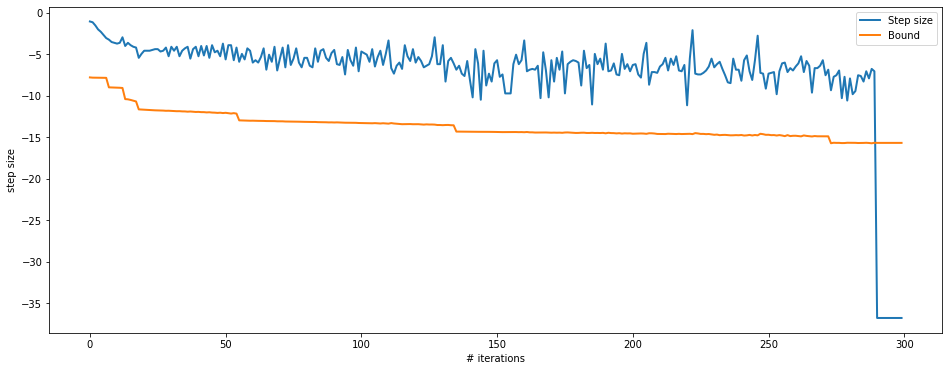

In [402]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(torch.log(step_sizes), label='Step size', linewidth=2.0)
plt.plot(torch.log(step_size_bounds), label='Bound', linewidth=2.0)
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('step size')
plt.show()
plt.close()

In [403]:
step_sizes

tensor([3.5049e-01, 3.1863e-01, 2.1763e-01, 1.3513e-01, 1.0153e-01, 6.9343e-02,
        4.7362e-02, 3.9143e-02, 2.9408e-02, 2.6735e-02, 2.4304e-02, 2.6735e-02,
        5.2099e-02, 1.8260e-02, 2.6735e-02, 2.0086e-02, 1.6600e-02, 1.5091e-02,
        4.3714e-03, 7.0401e-03, 1.0307e-02, 1.0307e-02, 1.0307e-02, 1.1338e-02,
        1.2472e-02, 1.2472e-02, 9.3704e-03, 1.0307e-02, 1.5091e-02, 5.2894e-03,
        1.6600e-02, 1.0307e-02, 1.6600e-02, 5.2894e-03, 1.0307e-02, 1.3719e-02,
        1.6600e-02, 3.9740e-03, 1.2472e-02, 1.6600e-02, 5.2894e-03, 1.8260e-02,
        5.8183e-03, 1.8260e-02, 4.3714e-03, 2.0086e-02, 8.5186e-03, 1.0307e-02,
        5.2894e-03, 2.4304e-02, 3.6127e-03, 2.0086e-02, 2.0086e-02, 3.2843e-03,
        1.5091e-02, 2.7143e-03, 7.0401e-03, 3.6127e-03, 1.3719e-02, 1.0307e-02,
        2.4675e-03, 3.2843e-03, 2.4675e-03, 4.8085e-03, 1.3719e-02, 1.0465e-03,
        6.4001e-03, 2.7143e-03, 1.6600e-02, 9.5134e-04, 3.9740e-03, 1.5091e-02,
        1.3929e-03, 2.0086e-02, 1.8539e-

In [404]:
step_size_bounds

tensor([4.1299e-04, 4.0153e-04, 4.0012e-04, 4.0045e-04, 3.9971e-04, 3.9704e-04,
        3.9197e-04, 1.2459e-04, 1.2339e-04, 1.2210e-04, 1.2050e-04, 1.1855e-04,
        1.1554e-04, 3.0240e-05, 2.9437e-05, 2.7345e-05, 2.4895e-05, 2.2749e-05,
        8.7571e-06, 8.5728e-06, 8.3702e-06, 8.2186e-06, 8.0477e-06, 7.9533e-06,
        7.8069e-06, 7.7361e-06, 7.5710e-06, 7.5728e-06, 7.3911e-06, 7.4324e-06,
        7.2666e-06, 7.1863e-06, 7.0249e-06, 7.0515e-06, 6.8797e-06, 6.8396e-06,
        6.6365e-06, 6.7781e-06, 6.5882e-06, 6.4148e-06, 6.4821e-06, 6.2868e-06,
        6.2776e-06, 6.0763e-06, 6.1855e-06, 5.9636e-06, 5.8943e-06, 5.7297e-06,
        5.8602e-06, 5.6213e-06, 5.7972e-06, 5.5121e-06, 5.2964e-06, 5.5663e-06,
        5.2594e-06, 2.3305e-06, 2.3056e-06, 2.2758e-06, 2.2715e-06, 2.2307e-06,
        2.2387e-06, 2.2131e-06, 2.1974e-06, 2.1930e-06, 2.1755e-06, 2.1452e-06,
        2.1439e-06, 2.1357e-06, 2.1271e-06, 2.0817e-06, 2.0854e-06, 2.0750e-06,
        2.0311e-06, 2.0235e-06, 2.0376e-

The figure illustrates the step size in each iteration and the corresponding bound below which any step size should be accepted. The fact that the step sizes have to decrease several orders of magnitude below the bound indicates that there is a severe problem. Furthermore, we can see that there is a drastic jump in iteration 6, when $t$ goes from $4\times10^{-2}$ to $4\times10^{-7}$, decreasing 5 orders in just one iteration. 

In [228]:
hard_constraints = False
f_0 = game_iterated_3.calculate_bellman_error()
eta = 1.0
rho = 1.0
c_vector = 1.0*torch.ones(game_iterated_3.n_restrictions,1).to(game_iterated_3.device)
c_vector = game_iterated_3.mask_equality_restrictions(c_vector)
with torch.no_grad():
  f = game_iterated_3.calculate_bellman_error()
  g_vector = game_iterated_3.calculate_restriction_vector(hard_constraints)
  grad_f_vector, grad_g_matrix = game_iterated_3.build_grad_tensors(hard_constraints)

  d0_vector, d0_2norm, duals_0_vector, A_matrix, b_vector = game_iterated_3.calculate_descent_direction(g_vector, grad_f_vector, grad_g_matrix)
  new_c_vector = game_iterated_3.update_c_vector(c_vector, duals_0_vector)
  d_vector, duals_vector, new_rho, mWe = game_iterated_3.calculate_feasible_direction(g_vector, new_c_vector, duals_0_vector, 
                                                                      d0_2norm, A_matrix, b_vector, rho, 
                                                                      grad_f_vector, grad_g_matrix)
  d_v, d_pi, duals = game_iterated_3.vec2dic(d_vector, duals_vector)
  bound_step_size = game_iterated_3.calculate_bound_step_size(duals_vector, new_c_vector, new_rho, d0_2norm, grad_g_matrix, mWe)     

In [229]:
theta = game_iterated_3.calculate_auxiliary_bellman_error(f, g_vector, c_vector)
grad_theta_vector = grad_f_vector + torch.einsum('ij,ik->jk', grad_g_matrix, c_vector)
decrement = (d_vector.view(-1) * grad_theta_vector.view(-1)).sum().item()
step_size = 0.5*bound_step_size

In [230]:
gamma_0 = 0.5
game_temp = game_iterated_3.copy_game()
# Update parameters performing step in feasible descent direction 
game_temp.v.data.add_(step_size * d_v)
for s, player in game_iterated_3.state_player_pairs():
  if game_temp.more_than_one_action(player, s):
    game_temp.pi[player][s].data.add_(step_size * d_pi[player][s])

pi_vector_temp = game_temp.pi2vec()
pi_sum_vector_temp = game_temp.pi_sum()
f_temp = game_temp.calculate_bellman_error()
g_vector_temp = game_temp.calculate_restriction_vector(hard_constraints)
theta_temp = game_temp.calculate_auxiliary_bellman_error(f_temp, g_vector_temp, c_vector)      

gamma = gamma_0 * torch.ones_like(duals_vector)
gamma[duals_vector < 0] = 1.0
gamma[-game_iterated_3.N_S_reduced['1']-game_iterated_3.N_S_reduced['2']:,:] = 0.0

theta_decreased = theta_temp <= theta #+ eta * step_size * decrement
NAt = game_iterated_3.N_A_total['1'] + game_iterated_3.N_A_total['2']
g_v_valid = torch.all(g_vector_temp[:NAt] <= (g_vector * gamma)[:NAt]).item()
g_pi_valid = torch.all(g_vector_temp[NAt:] <= (g_vector * gamma)[NAt:]).item()
g_valid = g_v_valid and g_pi_valid

In [231]:
print(theta_decreased, g_v_valid, g_pi_valid)

True False True


In [232]:
g_vector

tensor([[-9.2485e-01],
        [-5.2452e-06],
        [-9.2485e-01],
        [-2.8610e-06],
        [-1.4956e-01],
        [-7.4026e-01],
        [-1.4956e-01],
        [-7.4026e-01],
        [-1.1019e-01],
        [-1.1019e-01]])

In [233]:
g_vector_temp

tensor([[-9.2451e-01],
        [ 3.4952e-04],
        [-9.2450e-01],
        [ 3.5191e-04],
        [-1.4944e-01],
        [-7.4043e-01],
        [-1.4944e-01],
        [-7.4043e-01],
        [-1.1013e-01],
        [-1.1013e-01]], grad_fn=<CatBackward>)

In [234]:
duals_vector

tensor([[ 0.6816],
        [ 0.8092],
        [ 0.6816],
        [ 0.8092],
        [ 1.3956],
        [-0.4166],
        [ 1.3956],
        [-0.4166],
        [-1.0704],
        [-1.0703]])

In [235]:
g_vector_temp <= g_vector * gamma

tensor([[ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])

In [236]:
gamma

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [1.0000],
        [0.5000],
        [1.0000],
        [0.0000],
        [0.0000]])

In [237]:
norm_2_d = d_vector.pow(2).sum()
print(norm_2_d)

tensor(0.3048)


In [238]:
mu_vector = game_iterated_3.calculate_max_eigen_g_hessian()

In [239]:
mu_vector

tensor([[15.6184],
        [18.7268],
        [15.6185],
        [18.7268]])

In [240]:
g_vector[:NAt,:]

tensor([[-9.2485e-01],
        [-5.2452e-06],
        [-9.2485e-01],
        [-2.8610e-06]])

In [241]:
g_vector[:NAt,:] + step_size * torch.einsum('ij,jk->ik', grad_g_matrix[:NAt,:], d_vector) + 0.5*mu_vector*(step_size**2)*norm_2_d

tensor([[-9.2450e-01],
        [-6.2809e-06],
        [-9.2450e-01],
        [-3.8971e-06]])

In [242]:
g_vector_temp[:NAt,:]

tensor([[-9.2451e-01],
        [ 3.4952e-04],
        [-9.2450e-01],
        [ 3.5191e-04]], grad_fn=<SliceBackward>)

In [243]:
beta_1_tau = 1 + new_rho * d0_2norm**0.5 * torch.einsum('ji,jk->ik', grad_g_matrix, mWe).pow(2).sum()**0.5
beta_tau = beta_1_tau**(-2)
tau_lambda = (1-gamma_0) / (1.0 * (duals_vector + new_c_vector).max())
tau_mu = 2 * beta_tau * new_rho / mu_vector.max()
tau = np.infty
if duals_vector.max() > 0.0:
  tau = tau_lambda.item()
  if mu_vector.max() > 0.0:
    tau = min(tau, tau_mu.item())
else:
  if mu_vector.max() > 0.0:
    tau = tau_mu.item()

In [244]:
d0_2norm - beta_tau * norm_2_d

tensor(0.0350)

In [245]:
print(tau_mu, tau_lambda)

tensor(0.0011) tensor(0.3201)


In [246]:
step_size*2

0.0010919219348579645

In [247]:
mu_list = []
hessians = []
Tr_list = []
grad_g_v_dic, grad_g_pi_dic = game_iterated_3.nash_restriction_gradients(True)
dim = game_iterated_3.N_S + game_iterated_3.N_A_reduced['1'] + game_iterated_3.N_A_reduced['2']
NS = game_iterated_3.N_S
for player in game_iterated_3.players():
  other_player = game_iterated_3.other_player(player)
  NAi = game_iterated_3.N_A_reduced[player]
  NAmi = game_iterated_3.N_A_reduced[other_player]
  for state in game_iterated_3.S_no_string:
    s = str(state)
    pi_sum = game_iterated_3.pi[player][s].sum()
    next_v_matrix = grad_g_pi_dic[other_player][s]
    grad_g_v_matrix = grad_g_v_dic[player][s]
    for ai in range(0, game_iterated_3.A[player][s]):
      Tr = game_iterated_3.transition_matrix_given_sai(player, state, ai)
      M14 = game_iterated_3.beta * pi_sum * Tr 
      # next_v = next_v_matrix[ai,:].view(-1)
      Ri = game_iterated_3.R[player][s].clone()
      if player == '2':
        Ri = Ri.T
      v_player = game_iterated_3.v[:,game_iterated_3.get_player_id(player)].view(-1,1)
      next_v = Ri[ai,:].view(1,-1) + game_iterated_3.beta * torch.einsum('ji,jk->ki', Tr, v_player)
      #ones_1 = torch.ones(NAi,NAmi).to(game_iterated_3.device)
      ones_1 = torch.ones(NAi,1).to(game_iterated_3.device)
      M34 = torch.einsum('ij,jk->ik', ones_1, next_v) #torch.einsum('ij,jk->ik', ones_1, torch.diag(next_v))
      p = torch.einsum('ij,jk->ik', Tr, game_iterated_3.pi[other_player][s]) #grad_g_v_matrix[ai,:].view(-1)
      # id_s = game_iterated_3.get_state_index(s)
      # p[id_s] += 1
      #ones_2 = torch.ones(NS,NAi).to(game_iterated_3.device)
      ones_2 = torch.ones(NAi,1).to(game_iterated_3.device)
      M13 = game_iterated_3.beta * torch.einsum('ij,kj->ik', p, ones_2) #torch.einsum('ij,jk->ik', torch.diag(p), ones_2)
      
      M = torch.zeros(dim, dim).to(game_iterated_3.device)
      M[:NS,NS:NS+NAi] = M13.clone()
      M[:NS,NS+NAi:] = M14.clone()
      M[NS:NS+NAi,:NS] = M13.T.clone()
      M[NS:NS+NAi,NS+NAi:] = M34.clone()
      M[NS+NAi:,:NS] = M14.T.clone()
      M[NS+NAi:,NS:NS+NAi] = M34.T.clone()

      M_eigval, M_eigvec = torch.eig(M)
      mu_list.append(M_eigval.max())
      hessians.append(M.clone())
      Tr_list.append(Tr.clone())
mu_vector = torch.FloatTensor(mu_list).view(-1,1).to(game_iterated_3.device)

In [248]:
mu_vector

tensor([[15.6184],
        [18.7268],
        [15.6185],
        [18.7268]])

In [249]:
dg2_list = []
for i in range(0, NAt):
  d_reduced = torch.zeros(hessians[i].shape[0],1)
  if i < game_iterated_3.N_A_total['1']:
    d_reduced[:game_iterated_3.N_S,:] = d_vector[:game_iterated_3.N_S,:]
    d_reduced[game_iterated_3.N_S:,:] = d_vector[2*game_iterated_3.N_S:,:]
  else:
    d_reduced[:game_iterated_3.N_S,:] = d_vector[game_iterated_3.N_S:2*game_iterated_3.N_S,:]
    d_reduced[game_iterated_3.N_S:game_iterated_3.N_S+game_iterated_3.N_A_reduced['2'],:] = d_vector[2*game_iterated_3.N_S+game_iterated_3.N_A_reduced['1']:,:]
    d_reduced[game_iterated_3.N_S+game_iterated_3.N_A_reduced['2']:,:] = d_vector[2*game_iterated_3.N_S:2*game_iterated_3.N_S+game_iterated_3.N_A_reduced['1'],:]
  Hd = torch.einsum('ij,jk->ik', hessians[i], d_reduced)
  dg2_list.append((d_reduced.view(-1) * Hd.view(-1)).sum())
  print(i, hessians[i], d_reduced, (d_reduced * Hd).sum())
dg2_vector = torch.FloatTensor(dg2_list).to(game_iterated_3.device).view(-1,1)

0 tensor([[0.0000, 0.8809, 0.8809, 0.8809, 0.8809],
        [0.8809, 0.0000, 0.0000, 9.0644, 6.0644],
        [0.8809, 0.0000, 0.0000, 9.0644, 6.0644],
        [0.8809, 9.0644, 9.0644, 0.0000, 0.0000],
        [0.8809, 6.0644, 6.0644, 0.0000, 0.0000]], grad_fn=<CloneBackward>) tensor([[ 0.1140],
        [-0.2052],
        [ 0.3119],
        [-0.2052],
        [ 0.3119]]) tensor(0.0496, grad_fn=<SumBackward0>)
1 tensor([[ 0.0000,  0.8809,  0.8809,  0.8809,  0.8809],
        [ 0.8809,  0.0000,  0.0000, 11.0644,  7.0644],
        [ 0.8809,  0.0000,  0.0000, 11.0644,  7.0644],
        [ 0.8809, 11.0644, 11.0644,  0.0000,  0.0000],
        [ 0.8809,  7.0644,  7.0644,  0.0000,  0.0000]],
       grad_fn=<CloneBackward>) tensor([[ 0.1140],
        [-0.2052],
        [ 0.3119],
        [-0.2052],
        [ 0.3119]]) tensor(0.0285, grad_fn=<SumBackward0>)
2 tensor([[0.0000, 0.8809, 0.8809, 0.8809, 0.8809],
        [0.8809, 0.0000, 0.0000, 9.0644, 6.0644],
        [0.8809, 0.0000, 0.0000, 9.0644,

In [250]:
mu_vector*norm_2_d

tensor([[4.7608],
        [5.7083],
        [4.7608],
        [5.7083]])

In [251]:
for pname, p in game_iterated_3.named_parameters():
  print(pname, p)

v Parameter containing:
tensor([[6.1257, 6.1257]], requires_grad=True)
pi1.('G',) Parameter containing:
tensor([[0.1496],
        [0.7403]], requires_grad=True)
pi2.('G',) Parameter containing:
tensor([[0.1496],
        [0.7403]], requires_grad=True)


In [252]:
for pname, p in game_temp.named_parameters():
  print(pname, p)

v Parameter containing:
tensor([[6.1257, 6.1257]], requires_grad=True)
pi1.('G',) Parameter containing:
tensor([[0.1494],
        [0.7404]], requires_grad=True)
pi2.('G',) Parameter containing:
tensor([[0.1494],
        [0.7404]], requires_grad=True)


In [253]:
step_size * d_vector

tensor([[ 6.2246e-05],
        [ 6.2243e-05],
        [-1.1204e-04],
        [ 1.7029e-04],
        [-1.1205e-04],
        [ 1.7030e-04]])

In [254]:
dg3_list = []
i = 0
for player in game_iterated_3.players():
  other_player = game_iterated_3.other_player(player)
  d_v_i = d_v[:,game_iterated_3.get_player_id(player)].view(-1,1)
  for state in game_iterated_3.S_no_string:
    s = str(state)
    d_pi_mi = d_pi[other_player][s]
    d_pi_i_sum = d_pi[player][s].sum()
    for ai in range(0, game_iterated_3.A[player][s]):
      Tr = Tr_list[i]
      d_P = torch.einsum('ij,jk->ik', Tr, d_pi_mi)
      dPdv = (d_P.view(-1) * d_v_i.view(-1)).sum()
      dg3_list.append(game_iterated_3.beta * d_pi_i_sum * dPdv)
      i += 1
dg3_vector = torch.FloatTensor(dg3_list).to(game_iterated_3.device).view(-1,1)

In [255]:
dg1_vector = torch.einsum('ij,jk->ik', grad_g_matrix[:NAt,:], d_vector)

In [256]:
step_size**1 * dg1_vector

tensor([[ 3.4226e-04],
        [-1.8864e-06],
        [ 3.4227e-04],
        [-1.8869e-06]])

In [257]:
0.5*step_size**2 * dg2_vector

tensor([[7.3865e-09],
        [4.2530e-09],
        [7.3860e-09],
        [4.2525e-09]])

In [258]:
step_size**3 * dg3_vector

tensor([[2.0911e-13],
        [2.0911e-13],
        [2.0910e-13],
        [2.0910e-13]])

In [259]:
g_vector_temp_estimated = g_vector[:NAt,:] + step_size**1 * dg1_vector + 0.5*step_size**2 * dg2_vector + step_size**3 * dg3_vector

In [260]:
g_vector_temp_estimated

tensor([[-9.2451e-01],
        [-7.1274e-06],
        [-9.2450e-01],
        [-4.7436e-06]])

In [261]:
g_vector_temp[:NAt,:]

tensor([[-9.2451e-01],
        [ 3.4952e-04],
        [-9.2450e-01],
        [ 3.5191e-04]], grad_fn=<SliceBackward>)

In [262]:
q_estimated_temp = game_temp.bellman_partial_projection_other() # Dic. with an array of 'q'-values for each agent 
g_nash_temp = {'1':{}, '2':{}}
coef = 1.0
for s, player in game_temp.state_player_pairs():
  if not hard_constraints:
    coef = game_temp.pi[player][s].sum()
  g_nash_temp[player][s] = coef * q_estimated_temp[player][s] - game_temp.v[game_temp.get_state_index(s), game_temp.get_player_id(player)].item()

In [263]:
g_nash_temp

{'1': {"('G',)": tensor([[-9.2451e-01],
          [ 3.4952e-04]], grad_fn=<SubBackward0>)},
 '2': {"('G',)": tensor([[-9.2450e-01],
          [ 3.5191e-04]], grad_fn=<SubBackward0>)}}

In [264]:
q_estimated_3 = game_temp.bellman_partial_projection_other() # Dic. with an array of 'q'-values for each agent 
g_nash_3 = {'1':{}, '2':{}}
coef = 1.0
for s, player in game_iterated_3.state_player_pairs():
  if not hard_constraints: 
    coef = (game_iterated_3.pi[player][s] + step_size * d_pi[player][s]).sum()
  g_nash_3[player][s] = coef * q_estimated_3[player][s] - (game_iterated_3.v + step_size * d_v)[game_iterated_3.get_state_index(s), game_iterated_3.get_player_id(player)].item()

In [265]:
g_nash_3

{'1': {"('G',)": tensor([[-9.2451e-01],
          [ 3.4952e-04]], grad_fn=<SubBackward0>)},
 '2': {"('G',)": tensor([[-9.2450e-01],
          [ 3.5191e-04]], grad_fn=<SubBackward0>)}}

In [266]:
(game_temp.v.data - game_iterated_3.v.data)/step_size

tensor([[0.1144, 0.1144]])

In [267]:
(game_temp.pi2vec()['1'] - game_iterated_3.pi2vec()['1'])/step_size

tensor([[-0.2052],
        [ 0.3119]], grad_fn=<DivBackward0>)

In [268]:
r_mean_3 = {}
for player in game_iterated_3.players():
  r_mean_3[player] = {}
for s in game_iterated_3.S:
  RM1 = game_iterated_3.R['1'][s]
  RM2 = game_iterated_3.R['2'][s]
  strategy1 = game_iterated_3.pi['1'][s] + step_size * d_pi['1'][s]
  strategy2 = game_iterated_3.pi['2'][s] + step_size * d_pi['2'][s]
  r_mean_3['1'][s] = torch.einsum('ij,jk->ik', RM1, strategy2)
  r_mean_3['2'][s] = torch.einsum('ji,jk->ik', RM2, strategy1)

next_v_3 = {'1':{}, '2':{}}
for state in game_iterated_3.S_no_string:
  s = str(state)

  det, dep = game_iterated_3.transition_type[str(state)]
  N_A1 = game_iterated_3.A['1'][str(state)]
  N_A2 = game_iterated_3.A['2'][str(state)]
  vs = torch.zeros((N_A1,N_A2,2)).to(game_iterated_3.device)
  if det and dep: 
    for a1 in range(0,N_A1):
      for a2 in range(0,N_A2):
        _, next_state = game_iterated_3.transition_map(state, [a1,a2])
        vs[a1,a2,:] = (game_iterated_3.v + step_size * d_v)[game_iterated_3.get_state_index(next_state),:]
  elif (not det) and (not dep):
    _, transition_dic = game_iterated_3.transition_map(state, [])
    next_v = torch.zeros(1,2).to(game_iterated_3.device)
    for next_state, transition_prob in transition_dic:
      next_v = next_v + (game_iterated_3.v + step_size * d_v)[game_iterated_3.get_state_index(next_state),:].view(1,-1) * transition_prob      
    for a1 in range(0,N_A1):
      for a2 in range(0,N_A2):
        vs[a1,a2,:] = next_v.view(-1)

  next_state_value_matrix_3 = vs.clone()
  strategy_1 = (game_iterated_3.pi['1'][s] + step_size * d_pi['1'][s])
  strategy_2 = (game_iterated_3.pi['2'][s] + step_size * d_pi['2'][s])
  # mean next value when considering the strategy of the other player. Output: array of size m^i(s)
  next_v_3['1'][s] = torch.einsum('ij,jk->ik', next_state_value_matrix_3[:,:,0], strategy_2)
  next_v_3['2'][s] = torch.einsum('ji,jk->ik', next_state_value_matrix_3[:,:,1], strategy_1)
q_estimated_3 = {'1':{}, '2':{}}
for s, player in game_iterated_3.state_player_pairs():
  q_estimated_3[player][s] = r_mean_3[player][s] + game_iterated_3.beta * next_v_3[player][s]

g_nash_3 = {'1':{}, '2':{}}
coef = 1.0
for s, player in game_iterated_3.state_player_pairs():
  if not hard_constraints: 
    coef = (game_iterated_3.pi[player][s] + step_size * d_pi[player][s]).sum()
  g_nash_3[player][s] = coef * q_estimated_3[player][s] - (game_iterated_3.v + step_size * d_v)[game_iterated_3.get_state_index(s), game_iterated_3.get_player_id(player)].item()

In [269]:
g_nash_3

{'1': {"('G',)": tensor([[-9.2451e-01],
          [ 3.4952e-04]], grad_fn=<SubBackward0>)},
 '2': {"('G',)": tensor([[-9.2450e-01],
          [ 3.5191e-04]], grad_fn=<SubBackward0>)}}

In [270]:
i = 0
dg1_list = []
grad_g_v_dic_list = {'1':[], '2':[]}
grad_g_pi_dic_list = {'1':[], '2':[]}
beta = game_iterated_3.beta
for player in game_iterated_3.players():
  other_player = game_iterated_3.other_player(player)
  player_id = game_iterated_3.get_player_id(player)
  v_i = game_iterated_3.v[:,player_id].view(-1,1) 
  dv_i = d_v[:,player_id].view(-1,1)
  for state in game_iterated_3.S_no_string:
    s = str(state)
    s_id = game_iterated_3.get_state_index(s)
    pi_i = game_iterated_3.pi[player][s]
    pi_mi = game_iterated_3.pi[other_player][s]
    dpi_i = d_pi[player][s]
    dpi_mi = d_pi[other_player][s]    

    Ri_s = game_iterated_3.R[player][s].clone()
    if player == '2':
      Ri_s = Ri_s.T

    sum_pi = game_iterated_3.pi[player][s].sum()
    sum_dpi = d_pi[player][s].sum()

    for ai in range(0, game_iterated_3.A[player][s]):
      Tr = Tr_list[i]
      Ri_s_ai = Ri_s[ai,:].view(-1,1)

      P_pi_mi = torch.einsum('ij,jk->ik', Tr, pi_mi)
      P_dpi_mi = torch.einsum('ij,jk->ik', Tr, dpi_mi)
      R_pi_mi = torch.dot(Ri_s_ai.view(-1), pi_mi.view(-1))
      R_dpi_mi = torch.dot(Ri_s_ai.view(-1), dpi_mi.view(-1))
      P_pi_mi_dv_i = torch.dot(P_pi_mi.view(-1), dv_i.view(-1))
      P_dpi_mi_v_i = torch.dot(P_dpi_mi.view(-1), v_i.view(-1))
      P_pi_mi_v_i = torch.dot(P_pi_mi.view(-1), v_i.view(-1))

      dg1_s_ai = sum_pi * (beta * P_pi_mi_dv_i + R_dpi_mi + beta * P_dpi_mi_v_i)
      dg1_s_ai = dg1_s_ai + sum_dpi * (R_pi_mi + beta * P_pi_mi_v_i)
      dg1_s_ai = dg1_s_ai - dv_i.view(-1)[s_id]
      dg1_list.append(dg1_s_ai)

      grad_g_v_i = sum_pi * beta * P_pi_mi
      grad_g_v_i[s_id,0] = grad_g_v_i[s_id,0] - 1
      grad_g_v_dic_list[player].append(grad_g_v_i.view(1,-1))
      grad_g_v_dic_list[other_player].append(torch.zeros_like(grad_g_v_i).view(1,-1))

      mean_v_i = torch.einsum('ji,jk->ik', Tr, v_i)
      grad_g_pi_mi = sum_pi * (Ri_s_ai + beta * mean_v_i)
      grad_g_pi_dic_list[other_player].append(grad_g_pi_mi.view(1,-1))

      grad_g_pi_i = (R_pi_mi + beta * P_pi_mi_v_i) * torch.ones_like(pi_i)
      grad_g_pi_dic_list[player].append(grad_g_pi_i.view(1,-1))

      i = i + 1
dg1_vector_direct = torch.FloatTensor(dg1_list).to(game_iterated_3.device).view(-1,1)

In [271]:
dg1_vector_direct

tensor([[0.6269],
        [0.6501],
        [0.6269],
        [0.6501]])

In [272]:
dg1_vector

tensor([[ 0.6269],
        [-0.0035],
        [ 0.6269],
        [-0.0035]])

In [273]:
grad_g_matrix[:NAt,:]

tensor([[-0.2162,  0.0000,  5.8449,  5.8449,  8.0656,  5.3962],
        [-0.2162,  0.0000,  0.7586,  0.7586,  9.8453,  6.2860],
        [ 0.0000, -0.2162,  8.0656,  5.3962,  5.8449,  5.8449],
        [ 0.0000, -0.2162,  9.8453,  6.2860,  0.7586,  0.7586]])

In [274]:
grad_g_matrix[:NAt,:] @ d_vector

tensor([[ 0.6269],
        [-0.0035],
        [ 0.6269],
        [-0.0035]])

In [275]:
g_vector_temp_estimated_direct = g_vector[:NAt,:] + step_size**1 * dg1_vector_direct + 0.5*step_size**2 * dg2_vector + step_size**3 * dg3_vector

In [276]:
g_vector_temp_estimated_direct

tensor([[-9.2451e-01],
        [ 3.4970e-04],
        [-9.2450e-01],
        [ 3.5210e-04]])

In [277]:
g_vector_temp[:NAt,:]

tensor([[-9.2451e-01],
        [ 3.4952e-04],
        [-9.2450e-01],
        [ 3.5191e-04]], grad_fn=<SliceBackward>)

In [278]:
for player in game_iterated_3.players():
  grad_g_v_dic_list[player] = torch.cat(grad_g_v_dic_list[player], dim = 0)
  grad_g_pi_dic_list[player] = torch.cat(grad_g_pi_dic_list[player], dim = 0)

In [279]:
grad_g_v_dic_list

{'1': tensor([[-0.2162],
         [-0.2162],
         [ 0.0000],
         [ 0.0000]], grad_fn=<CatBackward>), '2': tensor([[ 0.0000],
         [ 0.0000],
         [-0.2162],
         [-0.2162]], grad_fn=<CatBackward>)}

In [280]:
grad_g_pi_dic_list

{'1': tensor([[5.8449, 5.8449],
         [6.8842, 6.8842],
         [8.0656, 5.3962],
         [9.8453, 6.2860]], grad_fn=<CatBackward>),
 '2': tensor([[8.0656, 5.3962],
         [9.8453, 6.2860],
         [5.8449, 5.8449],
         [6.8842, 6.8842]], grad_fn=<CatBackward>)}

In [408]:
game_iterated_4 = multi_player_game(N, S, A, R, T, beta, device).to(device)

In [412]:
step_sizes_4, step_size_bounds_4 = game_iterated_4.optimize_game(hard_constraints=False, verbose=False, n_epochs=30, on=True, eta_0=0.9, nu=1.5)[0:2]

Epoch: 0, f: 4.84732e+01, delta f: -1.97526e-03%, nash satisfied: True, max g: -6.784e-01, dual nash satisfied: False, max product: 6.351e+00, rho: 4.236e-04, norm2 d0:1.385e+01, ss: 1.760e-05
Epoch: 0, >0 satisfied: True, max g>0: -6.983e-04, dual >0 satisfied: False, max product >0: 4.471e-01, =1 satisfied: True, max g=1: -1.703e-01, dual =1 satisfied: False, max product =1: 3.971e+00
Epoch: 1, f: 4.84722e+01, delta f: -3.98199e-03%, nash satisfied: True, max g: -6.783e-01, dual nash satisfied: False, max product: 6.351e+00, rho: 4.236e-04, norm2 d0:1.385e+01, ss: 1.760e-05
Epoch: 1, >0 satisfied: True, max g>0: -6.983e-04, dual >0 satisfied: False, max product >0: 4.471e-01, =1 satisfied: True, max g=1: -1.703e-01, dual =1 satisfied: False, max product =1: 3.970e+00
Epoch: 2, f: 4.84712e+01, delta f: -5.95725e-03%, nash satisfied: True, max g: -6.783e-01, dual nash satisfied: False, max product: 6.350e+00, rho: 4.236e-04, norm2 d0:1.385e+01, ss: 1.760e-05
Epoch: 2, >0 satisfied: Tru

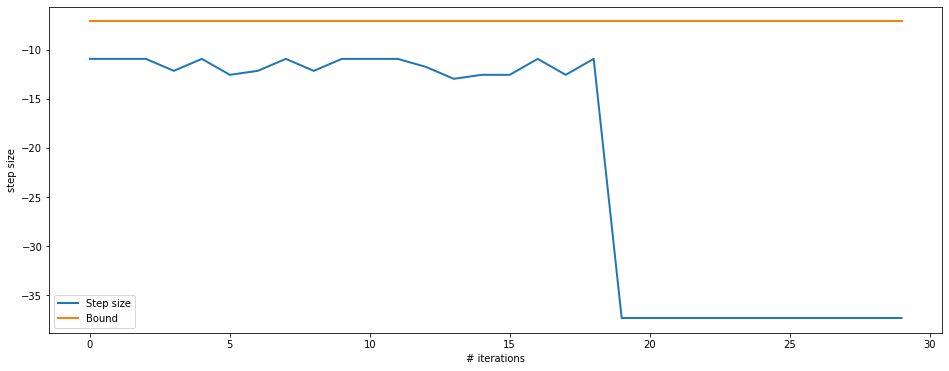

In [413]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(torch.log(step_sizes_4), label='Step size', linewidth=2.0)
plt.plot(torch.log(step_size_bounds_4), label='Bound', linewidth=2.0)
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('step size')
plt.show()
plt.close()

We can see that, just as in the case of the iterated version, the step size abruptly jumps from $10^{-6}$ $10^{-17}$. This indicates that once the boundary of the restrictions $\textbf{g}$ or a plateau region of the loss function $f$ is reached, the improvement stops altogether. We will need to confirm which of the two cases is the one causing the problem and then attempt to alleviate it. 